# This notebook contains code for vmPFC paper.


# Load Modules

In [1]:
%matplotlib inline

from collections import OrderedDict
import warnings
from copy import deepcopy
import glob
import os
import re
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind, pearsonr, wasserstein_distance
from scipy.linalg import norm
from scipy.signal import butter, filtfilt, freqz
from scipy.optimize import linear_sum_assignment
import itertools
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf
from hmmlearn import hmm

import nibabel as nib
from nilearn.plotting import plot_epi,plot_anat,plot_glass_brain,plot_stat_map

from nltools.data import Brain_Data, Adjacency, Design_Matrix
from nltools.stats import (fisher_r_to_z, 
                           downsample, 
                           threshold, 
                           upsample, 
                           zscore, 
                           pearson, 
                           align,
                           winsorize, 
                           fdr, 
                           regress,
                           isc, 
                           align_states)
from nltools.mask import expand_mask, collapse_mask
from nltools.plotting import scatterplot

from fnl_tools.stats import (sort_subject_clusters, 
                             calc_fft, 
                             validity_index, 
                             extract_max_timeseries,
                             create_average_concordance,
                             calculate_r_square,
                             cluster_consensus,
                             bootstrap_consensus,
                             min_subarray,
                             hmm_bic,
                             calc_max_cluster_consensus_concordance
                            )
from fnl_tools.plotting import (plot_recurrence,
                                plot_avg_state_timeseries,
                                plot_concordance,
                                plot_cluster_similarity)
from fnl_tools.utils import get_rect_coord, rec_to_time
from fnl_tools.data import create_long_annotation, create_long_character_annotation

from emotioncf import create_sub_by_item_matrix
from emotioncf.cf import NNMF_sgd, Mean, KNN, NNMF_multiplicative

from feat import Fex
from feat.plotting import draw_lineface, draw_muscles, draw_vectorfield, plot_face, predict
from feat.utils import load_h5

from pymer4.models import Lm, Lmer


warnings.filterwarnings('ignore')

base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

# base_dir = '/Users/ljchang/Dropbox/TV_fMRI/'

/Users/lukechang/anaconda3/lib/python3.7/site-packages/feat-0.0.1-py3.7.egg/feat/data.py:24: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index


In [2]:
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

# Group HMM (v3)
- Analysis for revision
- fit single HMM to subjects data - can't PCA reduce because different number of components per subject

In [4]:
# Set parameters
episode = 'ep01'
version = 'v3'
analysis = f'HMM_Combined_{version}'
study = 'Study2'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
roi = 19

center = lambda x: (x - np.mean(x, axis=0))
zscore = lambda x: (x - np.mean(x, axis=0))/np.std(x, axis=0)

# Check if directory exists
if not os.path.exists(os.path.join(base_dir, 'Analyses', analysis)):
    os.makedirs(os.path.join(base_dir, 'Analyses', analysis))

# Load mask
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)
        
file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))

for k in tqdm(range(2, 26)):
    
    # Check if file exists.
    weight_file = os.path.join(base_dir, 'Analyses', analysis, f'HMM_Patterns_{study}_{episode}_k{k}_ROI{roi}_{version}.nii.gz')

    model_fit = {}
    if not os.path.exists(weight_file):
        # Load Data
        data = {}
        for f in file_list:
            sub = os.path.basename(f).split('_')[0]
            data[sub] = zscore(pd.read_csv(f))
            data[sub]['Subject'] = sub
        combined_data = pd.concat([data[x] for x in data])
        combined_data.reset_index(inplace=True, drop=True)

        # Reduce Data Dimensionality
        target_var = 0.9
        pca = PCA(n_components=target_var)
        X = pd.DataFrame(pca.fit_transform(combined_data.drop(columns='Subject')))
        lengths = [combined_data.query('Subject==@x').shape[0] for x in combined_data['Subject'].unique()]

        # Fit HMM
        m1 = hmm.GaussianHMM(n_components=k, covariance_type="diag", algorithm='map', n_iter=500)
        m1.fit(X, lengths)
        model_fit[k] = m1.score(X)

        # Get HMM Weights
        brain = mask_x[roi].copy()
        brain.data = brain.data.astype(float)
        brain.data = np.repeat(np.reshape(brain.data, (-1,1)), k, axis=1).T
        brain.data[:, brain.data[0,:]==1] = pca.inverse_transform(m1.means_)

        # Write out Transition matrix
        transmat = pd.DataFrame(m1.transmat_)
        transmat.to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_TransitionMatrix_{study}_{episode}_k{k}_ROI{roi}_{version}.csv'))

        # Write out predicted states
        pred_model_fit = {}
        all_pred = []
        for sub in data:
            pred = {}
            p = m1.decode(X[combined_data['Subject']==sub], algorithm='viterbi')
            pred_model_fit[sub] = p[0]
            pred['Viterbi'] = p[1]
            pred['MAP'] = m1.decode(X[combined_data['Subject']==sub], algorithm='map')[1]
            pred_prob = m1.predict_proba(X[combined_data['Subject']==sub])
            for i in range(k):
                pred[f'Probability_{i}'] = pred_prob[:,i]
            proj = np.dot(X[combined_data['Subject']==sub], m1.means_.T)
            for i in range(k):
                pred[f'Projected_{i}'] = proj[:,i]
            pred = pd.DataFrame(pred)
            pred['Subject'] = sub
            all_pred.append(pred)
        all_pred = pd.concat(all_pred)
        all_pred.to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_{episode}_k{k}_ROI{roi}_{version}.csv'))
        pd.Series(pred_model_fit).to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_{episode}_k{k}_ROI{roi}_Modelfit_{version}.csv'))
        pd.Series(model_fit).to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_Modelfit_{study}_{episode}_k{k}_ROI{roi}_{version}.csv'))
    else:
        print('HMM already fit.')

100%|██████████| 24/24 [7:45:27<00:00, 1163.64s/it]  


## Find Optimal k
- max(derivative(LLE wrt k))

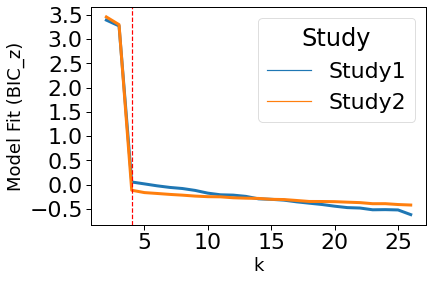

In [21]:
# base_dir = '/Volumes/Engram/Data/vmpfc'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
version = 'v3'
analysis = f'HMM_Combined_{version}'
roi = 32
episode = 'ep01'

center = lambda x: (x - np.mean(x, axis=0))
zscore = lambda x: (x - np.mean(x, axis=0))/np.std(x, axis=0)

model_fit_all = {}
for study in ['Study1', 'Study2']:
    file_list = glob.glob(os.path.join(base_dir,'Analyses', analysis, f'HMM_Modelfit_{study}_{episode}_k*_ROI{roi}_v3.csv'))
    if not file_list:
        file_list = glob.glob(os.path.join(base_dir,'Analyses', analysis, f'HMM_Modelfit_{study}_k*_ROI{roi}_v3.csv'))
        model_fit = {}
        for f in file_list:
            k = int(os.path.basename(f).split('_')[3][1:])
            model_fit[k] = pd.read_csv(f, index_col=0).values[0][0]
    else:
        model_fit = {}
        for f in file_list:
            k = int(os.path.basename(f).split('_')[4][1:])
            model_fit[k] = pd.read_csv(f, index_col=0).values[0][0]
    model_fit_all[study] = model_fit
model_fit = pd.DataFrame(model_fit_all)
model_fit['k'] = model_fit.index
model_fit = model_fit.melt(id_vars='k', value_vars=['Study1', 'Study2'], var_name='Study', value_name='LogLikelihood')
model_fit['BIC'] = hmm_bic(model_fit['LogLikelihood'], model_fit['k'])
model_fit['BIC_c'] = model_fit['BIC'].groupby(model_fit['Study']).transform(center)
model_fit['BIC_z'] = model_fit['BIC'].groupby(model_fit['Study']).transform(zscore)

study_model_fit = model_fit.query('Study==@study').sort_values('k')
k = study_model_fit['k'].iloc[np.where(study_model_fit['BIC'].diff() == study_model_fit['BIC'].diff().min())].values[0]

with sns.plotting_context(context='paper', font_scale=2.5):
    sns.lineplot(data=model_fit, x='k', y='BIC_z', hue='Study', linewidth=3)
    plt.ylabel('Model Fit (BIC_z)', fontsize=18)
    plt.xlabel('k', fontsize=18)
    plt.axvline(k, color='red', linestyle='--')
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'Modelfit_BIC_k{k}_ROI{roi}_{version}.pdf'))


## Create HMM Graphical Plot
*Study1*
- State 1 -> State 2
- State 2 -> State 4
- State 3 -> State 3
- State 4 -> State 1

*Study2*
- State 1 -> State 2
- State 2 -> State 4
- State 3 -> State 3
- State 4 -> State 1


In [514]:
base_dir = '/Volumes/Engram/Data/vmpfc'
version = 'v3'
analysis = f'HMM_Combined_{version}'
study = 'Study2'
k=4

transmat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_TransitionMatrix_{study}_k{k}_ROI{roi}_{version}.csv'), index_col=0)
transmat = Adjacency(transmat, matrix_type='directed')

ordered_trans = transmat.squareform()[:, [3,0,2,1]]
ordered_trans = ordered_trans[[3,0,2,1],:]
ordered_trans

array([[0.75734633, 0.00588276, 0.23178663, 0.00498427],
       [0.03420246, 0.44881075, 0.24411879, 0.27286799],
       [0.13790074, 0.01040706, 0.76216339, 0.08952881],
       [0.00771985, 0.0267085 , 0.3472961 , 0.61827555]])

## Plot State Concordance

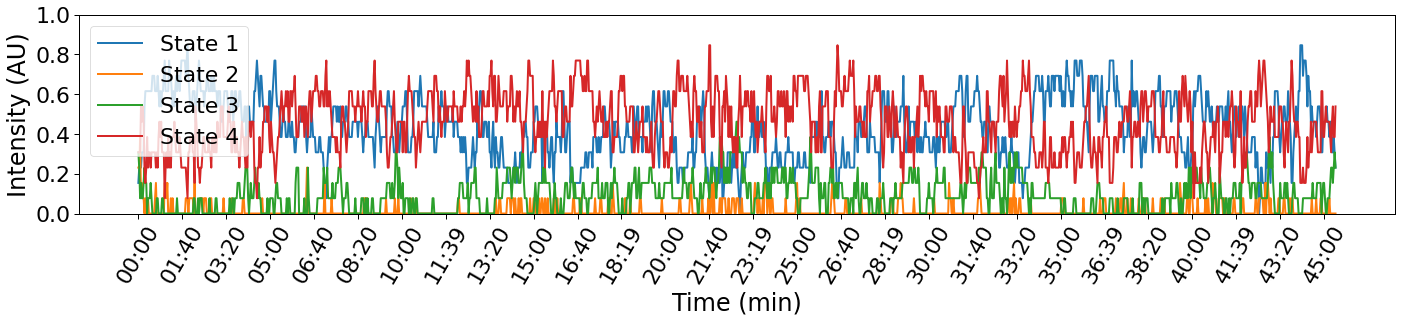

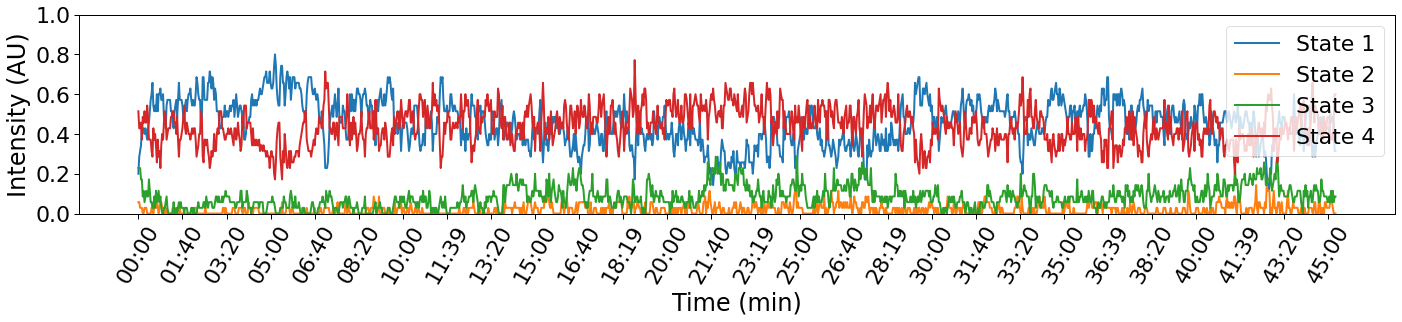

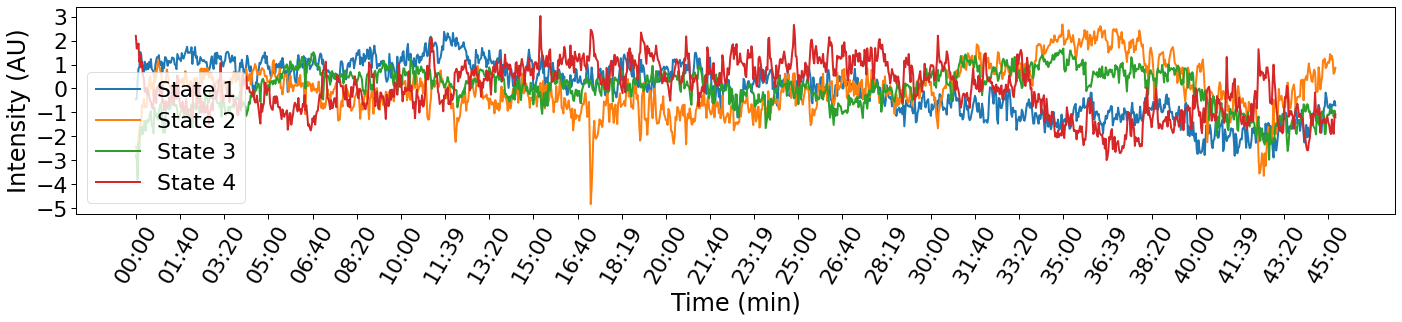

In [290]:
# base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
roi = 32
k = 4
study='Study1'
version='v3'
analysis = f'HMM_Combined_{version}'

s1_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_k{k}_ROI{roi}_{version}.csv'), index_col=0))
s2_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_k{k}_ROI{roi}_{version}.csv'), index_col=0))
common_model = pd.read_csv(os.path.join(base_dir, 'Figures', analysis, f'Experiment_SRM_Common_Timeseries_k{k}_{version}.csv'), index_col=0)

# s1_aligned = pd.DataFrame(align_states(common_model, s1_concord.iloc[:common_model.shape[0],:], replace_zero_variance=True))
# s2_aligned = pd.DataFrame(align_states(common_model, s2_concord.iloc[:common_model.shape[0],:], replace_zero_variance=True))

s1_aligned = s1_concord.copy()
s2_aligned = pd.DataFrame(align_states(s1_aligned.iloc[:common_model.shape[0],:], s2_concord.iloc[:common_model.shape[0],:], replace_zero_variance=True))

for study, concord in zip(['Study1', 'Study2', 'Common_Model'], [s1_aligned, s2_aligned, common_model]):
    with sns.plotting_context(context='paper', font_scale=2.5):
        f,a = plt.subplots(figsize=(20,5))
        a.plot(concord, linewidth=2)
        a.set_xticks(range(0, concord.shape[0], 50))
        a.set_xticklabels(rec_to_time(range(0, concord.shape[0], 50), TR=2.0), rotation=60)
        a.set_ylabel('Intensity (AU)')
        a.set_xlabel('Time (min)')
        if study != 'Common_Model':
            a.set_ylim([0,1])
#         plt.legend([f'State {x+1}' for x in range(k)])
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_State_Concordance_k{k}_ROI{roi}_{version}.pdf'))



## Study1 Episode 2


### Merge Prediction Files

In [595]:
roi = 32
episode = 'ep02'
version = 'v3'
analysis = f'HMM_Combined_{version}'
study = "Study1"
for k in tqdm(range(2,26)):
    file_list = glob.glob(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_{episode}_k{k}_ROI{roi}_{version}.csv'))
    predicted_states = []
    for f in file_list:
        predicted_states.append(pd.read_csv(f, index_col=0))

    predicted_states = pd.concat(predicted_states, axis=0)
    predicted_states.to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_{episode}_k{k}_ROI{roi}_{version}.csv'))


100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


### Plot State Concordance

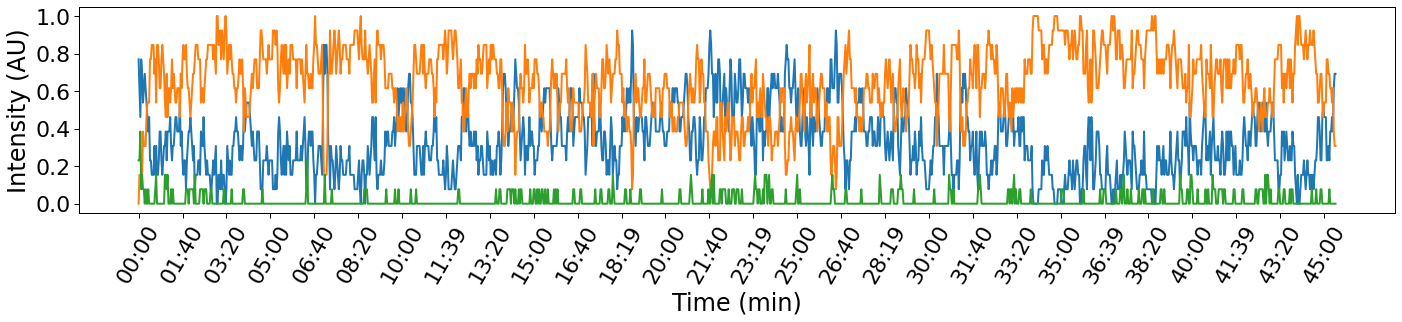

In [17]:
# base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
roi = 19
k = 3
study='Study1'
version='v3'
episode = 'ep01'
analysis = f'HMM_Combined_{version}'

s1_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_{episode}_k{k}_ROI{roi}_{version}.csv'), index_col=0))

with sns.plotting_context(context='paper', font_scale=2.5):
    f,a = plt.subplots(figsize=(20,5))
    a.plot(s1_concord, linewidth=2)
    a.set_xticks(range(0, s1_concord.shape[0], 50))
    a.set_xticklabels(rec_to_time(range(0, s1_concord.shape[0], 50), TR=2.0), rotation=60)
    a.set_ylabel('Intensity (AU)')
    a.set_xlabel('Time (min)')

#         plt.legend([f'State {x+1}' for x in range(k)])
    plt.tight_layout()
#         plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_State_Concordance_k{k}_ROI{roi}_{version}.pdf'))



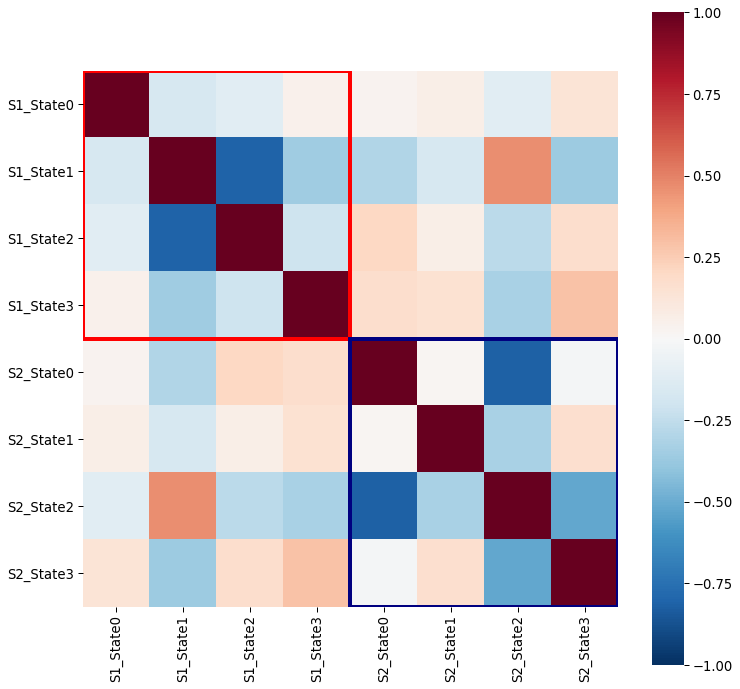

In [278]:
with sns.plotting_context(context='paper', font_scale=1.5):
    f,a = plt.subplots(figsize=(12,12))
    ts_similarity = 1 - pairwise_distances(np.concatenate([s1_aligned.T, s2_aligned.T], axis=0), metric='correlation')

    sns.heatmap(ts_similarity,cmap='RdBu_r', vmin=-1, vmax=1, 
                xticklabels=[f'S1_State{i}' for i in range(k)] + [f'S2_State{i}' for i in range(k)],
                yticklabels=[f'S1_State{i}' for i in range(k)] + [f'S2_State{i}' for i in range(k)], 
                square=True, ax=a)
    rect = patches.Rectangle((0,0), 4, 4, linewidth=4, edgecolor='red', facecolor='none')
    a.add_patch(rect)
    rect = patches.Rectangle((4,4), 4, 4, linewidth=4, edgecolor='navy', facecolor='none')
    a.add_patch(rect)
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'HMM_State_Concordance_Similarity_k{k}_ROI{roi}_{version}.pdf'))

## Train HMM on Episode 1 and Test on Episode 2

In [41]:
study = 'Study1'
k = 4
roi = 32
version = 'v3'
analysis = f'HMM_Combined_{version}'

# Load mask
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)
 
# Load Data
episode_data = {}
for episode in ['ep01', 'ep02']:
    file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
    file_list.sort()

    data = {}
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        data[sub] = zscore(pd.read_csv(f))
        data[sub]['Subject'] = sub
    combined_data = pd.concat([data[x] for x in data])
    combined_data.reset_index(inplace=True, drop=True)
    episode_data[episode] = combined_data
    
# Reduce Data Dimensionality
target_var = 0.9
episode_pca = {}
episode_X = {}
episode_lengths = {}
for episode in ['ep01', 'ep02']:
    episode_pca[episode] = PCA(n_components=target_var)
    episode_X[episode] = pd.DataFrame(episode_pca[episode].fit_transform(episode_data[episode].drop(columns='Subject')))
    episode_lengths[episode] = [episode_data[episode].query('Subject==@x').shape[0] for x in episode_data[episode]['Subject'].unique()]

# Fit HMM
episode_hmm = {}
for episode in ['ep01', 'ep02']:
    episode_hmm[episode] = hmm.GaussianHMM(n_components=k, covariance_type="diag", algorithm='map', n_iter=500)
    episode_hmm[episode].fit(episode_X[episode], episode_lengths[episode])

# Get HMM Weights
episode_brain = {}
for episode in ['ep01', 'ep02']:
    episode_brain[episode] = mask_x[roi].copy()
    episode_brain[episode].data = episode_brain[episode].data.astype(float)
    episode_brain[episode].data = np.repeat(np.reshape(episode_brain[episode].data, (-1,1)), k, axis=1).T
    episode_brain[episode].data[:, episode_brain[episode].data[0,:]==1] = episode_pca[episode].inverse_transform(episode_hmm[episode].means_)
    episode_brain[episode].write(os.path.join(base_dir, 'Analyses', analysis, f'{study}_{episode}_ROI{roi}_k{k}_HMM_Patterns_{version}.nii.gz'))
    
# Generate Model Predictions
for episode in ['ep01', 'ep02']:
    prediction = pd.DataFrame(episode_data[episode]['Subject'])
    prediction['Ep01Model_Subject_Model_Fit'] = np.nan
    prediction['Ep01Model_Subject_State_Viterbi'] = np.nan
    prediction['Ep02Model_Subject_Model_Fit'] = np.nan
    prediction['Ep02Model_Subject_State_Viterbi'] = np.nan
    prediction['Time'] = np.nan
    for sub in prediction['Subject'].unique():
        prediction.loc[prediction['Subject']==sub, 'Time'] = np.arange(0, episode_data[episode].query('Subject==@sub').shape[0])
        p1 = episode_hmm['ep01'].decode(episode_pca['ep01'].transform(episode_data[episode].query('Subject==@sub').drop(columns='Subject')), algorithm='viterbi')
        p2 = episode_hmm['ep02'].decode(episode_pca['ep02'].transform(episode_data[episode].query('Subject==@sub').drop(columns='Subject')), algorithm='viterbi')
        prediction.loc[prediction['Subject']==sub, 'Ep01Model_Subject_Model_Fit'] = p1[0]
        prediction.loc[prediction['Subject']==sub, 'Ep01Model_Subject_State_Viterbi'] = p1[1]
        prediction.loc[prediction['Subject']==sub, 'Ep02Model_Subject_Model_Fit'] = p2[0]
        prediction.loc[prediction['Subject']==sub, 'Ep02Model_Subject_State_Viterbi'] = p2[1]
    prediction.to_csv(os.path.join(base_dir, 'Analyses', analysis, f'{study}_{episode}_ROI{roi}_k{k}_HMM_Predictions_{version}.csv'))


In [45]:
def create_average_concordance(data, values='Viterbi', index=None):
    states = data.pivot(columns='Subject', values=values, index=index)
    n_states = len(np.unique(states.dropna()))
    concordance = {}
    for i in range(n_states):
        concordance[f'State_{i}'] = (states == i).mean(axis=1)
    return pd.DataFrame(concordance)
    
study = 'Study1'
k = 4
roi = 32
version = 'v3'
analysis = f'HMM_Combined_{version}'
episode = 'ep01'

concord_corr = {}
for episode in ['ep01', 'ep02']:
    print(episode)
    prediction = pd.read_csv(os.path.join(base_dir, 'Analyses', analysis, f'{study}_{episode}_ROI{roi}_k{k}_HMM_Predictions_{version}.csv'), index_col=0)
    prediction['Time'] = prediction['Time'].astype(int)
    ep1_concord = create_average_concordance(prediction, values='Ep01Model_Subject_State_Viterbi', index='Time' )
    ep2_concord = create_average_concordance(prediction, values='Ep02Model_Subject_State_Viterbi', index='Time' )
    ep2_remapping = align_states(ep1_concord, ep2_concord, return_index=True)
    ep2_concord = ep2_concord.iloc[:, ep2_remapping]
    ep2_concord.columns = ep1_concord.columns

    print('\nConcordance Correlation')

    with sns.plotting_context(context='paper', font_scale=2):
        f,a = plt.subplots(nrows=k, ncols=1, figsize=(15, k*3), sharex=True, sharey=True)
        for i in range(k):
            r = pearsonr(ep1_concord[f'State_{i}'], ep2_concord[f'State_{i}'])
            print(r)
            a[i].plot(ep1_concord[f'State_{i}'], linewidth=2)
            a[i].plot(ep2_concord[f'State_{i}'], linewidth=2)
            a[i].legend(['Episode 1 Model', 'Episode 2 Model'], bbox_to_anchor=(1.025, .5), loc='center left',)
            a[i].set_title(f'State {i+1}; r = {r[0]:.02}')
            a[i].set_ylabel('Concordance')
        a[i].set_xticks(range(0, ep1_concord.shape[0], 50))
        a[i].set_xticklabels(rec_to_time(range(0, ep1_concord.shape[0], 50), TR=2.0), rotation=60)
        a[i].set_xlabel('Time (min)')
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Concordance_Test_{episode}_ROI{roi}_k{k}.pdf'))
        plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Concordance_Test_{episode}_ROI{roi}_k{k}.png'), dpi=300)
        plt.close()
        
    concord_corr[episode] = pd.concat([ep1_concord, ep2_concord], axis=1).corr()
        
with sns.plotting_context(context='paper', font_scale=1.5):
    sns.heatmap((concord_corr['ep01'] + concord_corr['ep02'])/2, 
    cmap='RdBu_r', vmin=-1, vmax=1,square=True,
    xticklabels=[f'Ep01_S{i}' for i in range(k)] + [f'Ep02_S{i}' for i in range(k)],
    yticklabels=[f'Ep01_S{i}' for i in range(k)] + [f'Ep02_S{i}' for i in range(k)])
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Aligned_Avg_Concordance_Similarity_ep01_ep02_ROI{roi}_k{k}.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Aligned_Avg_Concordance_Similarity_ep01_ep02_ROI{roi}_k{k}.png'), dpi=300)
    plt.close()
    
print('\nConcordance Correlation')
ep2_brain_aligned = episode_brain['ep02'][ep2_remapping]
for x,y in zip(episode_brain['ep01'], ep2_brain_aligned):
    print(x.apply_mask(mask_x[roi]).similarity(y.apply_mask(mask_x[roi])))
    
with sns.plotting_context(context='paper', font_scale=1.5):
    brain_weights = episode_brain['ep01'].append(ep2_brain_aligned)
    brain_weight_similarity = 1 - brain_weights.apply_mask(mask_x[roi]).distance(metric='correlation')
    brain_weight_similarity.labels = [f'Ep01_S{x}' for x in range(k)] + [f'Ep02_S{x}' for x in range(k)]
    sns.heatmap(brain_weight_similarity.squareform() + np.diag(np.ones(brain_weight_similarity.square_shape()[0])), 
        cmap='RdBu_r', vmin=-1, vmax=1,square=True,
        xticklabels=[f'Ep01_S{i}' for i in range(k)] + [f'Ep02_S{i}' for i in range(k)],
        yticklabels=[f'Ep01_S{i}' for i in range(k)] + [f'Ep02_S{i}' for i in range(k)])
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Aligned_Spatial_Similarity_ep01_ep02_ROI{roi}_k{k}.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Aligned_Spatial_Similarity_ep01_ep02_ROI{roi}_k{k}.png'), dpi=300)
    plt.close()



ep01

Concordance Correlation
(0.6390664670593611, 1.892222197485981e-157)
(-0.032733735544004945, 0.22698962995797953)
(0.9999999999999998, 0.0)
(0.2969688764092576, 3.577052861123139e-29)
ep02

Concordance Correlation
(0.7116672245313437, 6.97144357988668e-204)
(0.010536688237686005, 0.7024397466652249)
(1.0, 0.0)
(0.29560168064755354, 5.739338566446138e-28)

Concordance Correlation
0.27505317056189066
0.1090051688415171
0.026510952626177087
0.2769578866597192


In [46]:
remap = [3, 0, 2, 1, 7, 4, 6, 5]
concord_corr['ep01'] = concord_corr['ep01'].iloc[:, remap]
concord_corr['ep01'] = concord_corr['ep01'].iloc[remap, :]
concord_corr['ep02'] = concord_corr['ep02'].iloc[:, remap]
concord_corr['ep02'] = concord_corr['ep02'].iloc[remap, :]

with sns.plotting_context(context='paper', font_scale=1.5):
    sns.heatmap((concord_corr['ep01'] + concord_corr['ep02'])/2, 
    cmap='RdBu_r', vmin=-1, vmax=1,square=True,
    xticklabels=[f'Ep01_S{i}' for i in range(k)] + [f'Ep02_S{i}' for i in range(k)],
    yticklabels=[f'Ep01_S{i}' for i in range(k)] + [f'Ep02_S{i}' for i in range(k)])
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Aligned_Avg_Concordance_Similarity_ep01_ep02_ROI{roi}_k{k}.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_HMM_Aligned_Avg_Concordance_Similarity_ep01_ep02_ROI{roi}_k{k}.png'), dpi=300)
    plt.close()

# Individual HMM  (v4)
- fit HMM separately to each participant
- identify k by the one that maximizes the consistency of the matching metric
- matching metric - from Wiltscko et al., 2015 neuron
    - frobenius norm between the G-HMM state matrices
    - then use munkres matching algorithm (hungarian algorithm) to generate a mapping from first to second subject
    

In [137]:
# Set parameters
# base_dir = '/dartfs/rc/lab/D/DBIC/cosanlab/datax/Projects/vmpfc'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

roi = 19
episode = 'ep01'
version = 'v4'
var_exp = .9
analysis = f'HMM_Combined_{version}'
overwrite = False

if not os.path.exists(os.path.join(base_dir, 'Analyses', analysis)):
    os.makedirs(os.path.join(base_dir, 'Analyses', analysis))

for study in ['Study1', 'Study2']:
    file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))

    # Load mask
    mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
    mask_x = expand_mask(mask)

    for f in tqdm(file_list):
        for k in range(2, 26):

            # Load Data
            dat = pd.read_csv(f)
            sub = os.path.basename(f).split('_')[0]

            # Check if file exists.
            weight_file = os.path.join(base_dir, 'Analyses', analysis, f'HMM_Patterns_{study}_{sub}_k{k}_ROI{roi}_{version}.nii.gz')

            # Perform PCA
            pca = PCA(n_components=var_exp)
            reduced = pca.fit_transform(zscore(dat))

            # Run HMM
            m1 = hmm.GaussianHMM(n_components=k, covariance_type="diag", algorithm='map', n_iter=500)
            m1.fit(reduced)

            # Get HMM Weights
            brain = mask_x[roi].copy()
            brain.data = brain.data.astype(float)
            brain.data = np.repeat(np.reshape(brain.data, (-1,1)), k, axis=1).T
            brain.data[:, brain.data[0,:]==1] = pca.inverse_transform(m1.means_)
            brain.write(weight_file)

            # Write out HMM Covariance
            for i,x in enumerate(m1.covars_):
                pd.DataFrame(x).to_csv(os.path.join(base_dir, 'Analyses', analysis, f'HMM_Covariance_State{i}_{study}_{sub}_k{k}_ROI{roi}_{version}.csv'))

            # Write out Transition matrix
            transmat = pd.DataFrame(m1.transmat_)
            transmat.to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_TransitionMatrix_{study}_{sub}_k{k}_ROI{roi}_{version}.csv'))

            # Write out predicted states
            pred = {}
            p = m1.decode(reduced, algorithm='viterbi')
            pred['Viterbi'] = p[1]
            pred['MAP'] = m1.decode(reduced, algorithm='map')[1]
            pred_prob = m1.predict_proba(reduced)
            for i in range(k):
                pred[f'Probability_{i}'] = pred_prob[:,i]
            proj = np.dot(reduced, m1.means_.T)
            for i in range(k):
                pred[f'Projected_{i}'] = proj[:,i]
            pred = pd.DataFrame(pred)
            pred['ModelFit'] = m1.score(reduced)
            pred['Subject'] = sub
            pred['Study'] = study
            pred['PCA_Components'] = reduced.shape[1]
            pred.to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_{sub}_k{k}_ROI{roi}_{version}.csv'))


100%|██████████| 35/35 [2:15:21<00:00, 232.05s/it]  


## Merge Prediction Files


In [138]:
roi = 19
version = 'v4'
analysis = f'HMM_Combined_{version}'

for study in ['Study1', 'Study2']:
    for k in tqdm(range(2,26)):
        file_list = glob.glob(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_*_k{k}_ROI{roi}_{version}.csv'))
        predicted_states = []
        for f in file_list:
            predicted_states.append(pd.read_csv(f, index_col=0))

        predicted_states = pd.concat(predicted_states, axis=0)
        predicted_states.to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}.csv'))


100%|██████████| 24/24 [01:23<00:00,  3.46s/it]


## Get Overall Model Fit

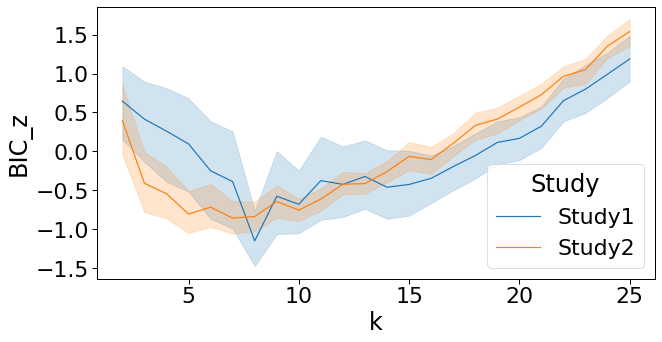

In [139]:
roi = 19
version = 'v4'
analysis = f'HMM_Combined_{version}'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

combined_model_fit = []
for study in ['Study1', 'Study2']:
    model_fit = []
    for k in range(2,26):
        file_list = glob.glob(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_*_k{k}_ROI{roi}_{version}.csv'))
        model_fit_k = []
        for f in file_list:
            p = pd.read_csv(f, index_col=0)
            model_fit_k.append({'Study':study, 'k':k, 'Subject':p['Subject'].unique()[0], 'ModelFit':p['ModelFit'].unique()[0], 'PCA_Components':p['PCA_Components'].unique()[0]})
        model_fit.append(pd.DataFrame(model_fit_k))
    model_fit = pd.concat(model_fit)
    model_fit.reset_index(inplace=True, drop=True)
    model_fit['BIC'] = [hmm_bic(LL=x[1]['ModelFit'], n_states=x[1]['k'], n_features=x[1]['PCA_Components']) for x in model_fit.iterrows()]
    demean = lambda x: (x - x.mean())
    zscore = lambda x: (x - x.mean())/x.std()
    model_fit['BIC_c'] = model_fit['BIC'].groupby(model_fit['Subject']).transform(demean)
    model_fit['BIC_z'] = model_fit['BIC'].groupby(model_fit['Subject']).transform(zscore)
    combined_model_fit.append(model_fit)
combined_model_fit = pd.concat(combined_model_fit)

with sns.plotting_context(context='paper', font_scale=2.5):
    f,a = plt.subplots(figsize=(10,5))
    sns.lineplot(data=combined_model_fit, x='k', y='BIC_z', hue='Study')
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'Modelfit_BIC_k{k}_ROI{roi}_{version}.pdf'))


In [507]:
print(f'ROI{roi}: n_voxels={np.sum(mask_x[roi].data)}')
print(combined_model_fit.groupby('Study').mean())

print(combined_model_fit.groupby('Study').std())


ROI4: n_voxels=2786
           k       ModelFit  PCA_Components            BIC         BIC_c  \
Study                                                                      
Study1  13.5 -135125.544476       33.692308  278471.574423  1.417879e-11   
Study2  13.5 -112226.402368       28.000000  231563.911951  2.945030e-12   

               BIC_z  
Study                 
Study1  4.868079e-15  
Study2  2.804635e-16  
               k      ModelFit  PCA_Components           BIC        BIC_c  \
Study                                                                       
Study1  6.933307  17833.647966        5.006254  36465.942476  3126.651280   
Study2  6.926311  23621.530112        6.418091  48395.096275  2725.037591   

           BIC_z  
Study             
Study1  0.980518  
Study2  0.979528  


# Align HMM States
- Align all states to a randomly chosen subject using hungarian algorithm. 
- write out new aligned weight maps and predicted state time series.

In [141]:
roi=32
study = 'Study1'
version = 'v4'
analysis = f'HMM_Combined_{version}'
# base_dir = '/Volumes/Engram/Data/vmpfc/'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

for study in ['Study1', 'Study2']:
    for k in tqdm(range(2,26)):

        file_list = glob.glob(os.path.join(base_dir, 'Analyses', analysis, f'HMM_Patterns_{study}_*_k{k}_ROI{roi}_{version}.nii.gz'))
        weights = [Brain_Data(f).apply_mask(mask_x[roi]).data for f in file_list]
        sub_list = [os.path.basename(x).split('_')[3] for x in file_list]
        predicted_states = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}.csv'), index_col=0)

        # remap all states to randomly selected subject using hungarian algorithm
        reference = weights[np.random.choice(range(len(sub_list)))].T
        ordered_weights = []
        new_mapping = []
        for i,w in enumerate(weights):
            ordered_weights.append(align_states(reference, w.T, metric='correlation', return_index=False, replace_zero_variance=True))
            new_mapping.append(align_states(reference, w.T, metric='correlation', return_index=True, replace_zero_variance=True))

        # Remap states in brain weight and write to file
        for i,f in enumerate(file_list):
            brain = mask_x[roi].copy()
            brain.data = brain.data.astype(float)
            brain.data = np.repeat(np.reshape(brain.data, (-1,1)), k, axis=1).T
            brain.data[:, brain.data[0,:]==1] = ordered_weights[i].T
            brain.write(os.path.join(base_dir,'Analyses', analysis, f"{os.path.basename(f).split('.')[0]}_aligned.nii.gz"))

        # Remap states in timeseries predictions and write to file
        mapping = {}
        for sub,new in zip(sub_list, new_mapping):
            mapping[sub] = {x:y for x,y in zip(range(k), new)}

        combined_subs = []
        for sub in sub_list:
            sub_data = predicted_states.query('Subject==@sub')
            sub_data['Viterbi'].replace(mapping[sub], inplace=True)
            sub_data['MAP'].replace(mapping[sub], inplace=True)
            combined_subs.append(sub_data)
        combined_subs = pd.concat(combined_subs)
        combined_subs.to_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}_aligned.csv'))
 
        # Remap Transition probability matrices and write to file
        transition_file_list = [os.path.join(base_dir, 'Analyses', analysis, f'HMM_TransitionMatrix_{study}_{x}_k{k}_ROI{roi}_{version}.csv') for x in sub_list]
        for i, tm_file in enumerate(transition_file_list):
            tm = pd.read_csv(transition_file_list[i], index_col=0)
            new_tm = tm.iloc[:,new_mapping[i]]
            new_tm = new_tm.iloc[new_mapping[i],:]
            new_tm.to_csv(os.path.join(base_dir, 'Analyses', analysis, f'HMM_TransitionMatrix_{study}_{sub_list[i]}_k{k}_ROI{roi}_{version}_aligned.csv'), index=False)


100%|██████████| 24/24 [17:13<00:00, 43.07s/it]


## Plot Spatial Similarity

In [304]:
roi=4
study = 'Study1'
version = 'v4'
analysis = f'HMM_Combined_{version}'

for study in ['Study1', 'Study2']:
    for k in tqdm(range(2,26)):
        file_list = glob.glob(os.path.join(base_dir,'Analyses', analysis, f'HMM_Patterns_{study}_*_k{k}_ROI{roi}_{version}_aligned.nii.gz'))
        file_list.sort()
        all_dat = []
        clusters = []
        for f in file_list:
            sub_dat = Brain_Data(f)
            all_dat.append(sub_dat)
            clusters.append(np.arange(len(sub_dat)))
        weights = Brain_Data(all_dat)
        clusters = np.hstack(clusters)

        unique_clusters = np.unique(clusters)
        ordered_weights = []
        ordered_clusters = []
        for c in unique_clusters:
            ordered_weights.append(weights[clusters==c])
            ordered_clusters.append(clusters[clusters==c])
        weights = Brain_Data(ordered_weights)
        clusters = np.hstack(ordered_clusters)
        state_similarity = 1 - weights.apply_mask(mask_x[roi]).distance(metric='correlation')

        plot_cluster_similarity(state_similarity.squareform() + np.eye(state_similarity.square_shape()[0]), labels=clusters, line_width=5)
        plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'Cluster_Spatial_Similarity_{study}_k{k}_roi{roi}.pdf' ))
        plt.close()

    #     print(f"\n{k}")
    #     print(state_similarity.cluster_summary(clusters=clusters, summary='within'))
    #     print(state_similarity.cluster_summary(clusters=clusters, summary='between'))


## Cluster Consensus

In [142]:
roi=19
version = 'v4'
analysis = f'HMM_Combined_{version}'
n_bootstraps = 10
align = False

for study in ['Study1', 'Study2']:
    consensus_max = {}
    consensus_mean = {}
    consensus_median = {}
    consensus_within_between = {}
    for k in tqdm(range(2,26)):
        file_list = glob.glob(os.path.join(base_dir, 'Analyses', analysis, f'HMM_Patterns_{study}_*_k{k}_ROI{roi}_{version}_aligned.nii.gz'))
        file_list.sort()
        weights = [Brain_Data(f).apply_mask(mask_x[roi]).data for f in file_list]
        consensus_mean[k] = bootstrap_consensus(weights, n_bootstraps=n_bootstraps, align=align, consensus_metric='mean')
        consensus_median[k] = bootstrap_consensus(weights, n_bootstraps=n_bootstraps, align=align, consensus_metric='median')
        consensus_max[k] = bootstrap_consensus(weights, n_bootstraps=n_bootstraps, align=align, consensus_metric='max')
        consensus_within_between[k] = bootstrap_consensus(weights, n_bootstraps=n_bootstraps, align=align, consensus_metric='within_between')

    consensus_mean = pd.DataFrame(consensus_mean)
    consensus_median = pd.DataFrame(consensus_median)
    consensus_max = pd.DataFrame(consensus_max)
    consensus_within_between = pd.DataFrame(consensus_within_between)

    consensus_mean_long = pd.melt(pd.DataFrame(consensus_mean), var_name='k', value_name='consensus')
    consensus_median_long = pd.melt(pd.DataFrame(consensus_median), var_name='k', value_name='consensus')
    consensus_max_long = pd.melt(pd.DataFrame(consensus_max), var_name='k', value_name='consensus')
    consensus_within_between_long = pd.melt(pd.DataFrame(consensus_within_between), var_name='k', value_name='consensus')

    combined_consensus = pd.concat([consensus_mean_long, consensus_median_long['consensus'], consensus_max_long['consensus'], consensus_within_between_long['consensus']], axis=1)
    combined_consensus.columns = ['k', 'Mean', 'Median', 'Max', 'Within_Between']
    combined_consensus.to_csv(os.path.join(base_dir, 'Analyses', analysis, f'Consensus_Metric_{study}_roi{roi}_bootstrap{n_bootstraps}.csv' ))


100%|██████████| 24/24 [11:22<00:00, 28.42s/it]


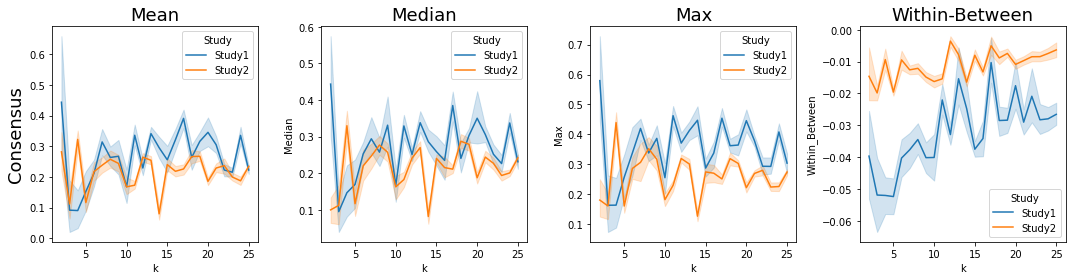

In [51]:
roi = 19
version = 'v4'
analysis = f'HMM_Combined_{version}'
n_bootstraps = 10

combined_consensus = []
for study in ['Study1', 'Study2']:
    consensus = pd.read_csv(os.path.join(base_dir, 'Analyses', analysis, f'Consensus_Metric_{study}_roi{roi}_bootstrap{n_bootstraps}.csv' ), index_col=0)
    consensus['Study'] = study
    combined_consensus.append(consensus)
combined_consensus = pd.concat(combined_consensus)

f,a = plt.subplots(ncols=4, figsize=(15,4), sharey=False)
sns.lineplot(data=combined_consensus, x='k', y='Mean', hue='Study', ax=a[0])
sns.lineplot(data=combined_consensus, x='k', y='Median', hue='Study', ax=a[1])
sns.lineplot(data=combined_consensus, x='k', y='Max', hue='Study', ax=a[2])
sns.lineplot(data=combined_consensus, x='k', y='Within_Between', hue='Study', ax=a[3])
a[0].set_title('Mean', fontsize=18)
a[1].set_title('Median', fontsize=18)
a[2].set_title('Max', fontsize=18)
a[3].set_title('Within-Between', fontsize=18)
a[0].set_ylabel('Consensus', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(base_dir,'Figures', analysis, f'HMM_ModelFit_SpatialSimilarity_ROI{roi}_{version}.pdf'))


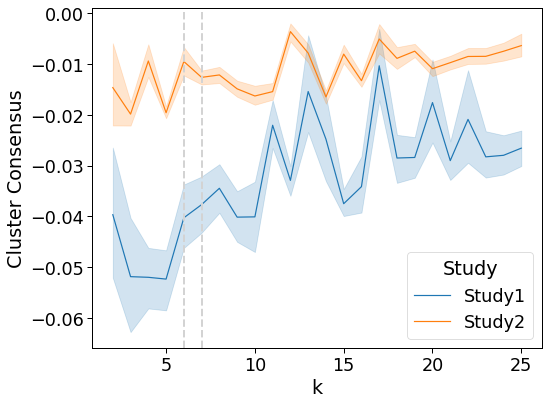

In [41]:
with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(ncols=1, figsize=(8,6))
    sns.lineplot(data=combined_consensus, x='k', y='Within_Between', hue='Study', ax=a)
    a.set_ylabel('Cluster Consensus')
    plt.axvline(6, color='lightgrey', linestyle='--', linewidth=2)
    plt.axvline(7, color='lightgrey', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures', analysis, f'HMM_ClusterConsensus_ROI{roi}_{version}.pdf'))


## Plot Spatial Patterns k=4
### Plot each subject

In [99]:
roi=32
k=4
version = 'v4'
analysis = f'HMM_Combined_{version}'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

for study in ['Study1', 'Study2']:
    file_list = glob.glob(os.path.join(base_dir, 'Analyses', analysis, f'HMM_Patterns_{study}_*_k{k}_ROI{roi}_{version}_aligned.nii.gz'))
    file_list.sort()
    f,a = plt.subplots(ncols=4, nrows=int(len(file_list)), figsize = (3*k, 3*int(len(file_list))))
    for i,s in enumerate(file_list):
        sdat = Brain_Data(s)
        for j in range(k):
            plot_glass_brain(sdat[j].to_nifti(), display_mode='x', cmap='RdBu_r', axes=a[i,j], plot_abs=False)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures', analysis, f'HMM_{study}_SpatialPattern_ROI{roi}_{version}.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures', analysis, f'HMM_{study}_SpatialPattern_ROI{roi}_{version}.png'), dpi=300)
    plt.close()

### Plot Subject Averages

In [105]:
study = 'Study2'

for study in tqdm(['Study1', 'Study2']):
    file_list = glob.glob(os.path.join(base_dir, 'Analyses', analysis, f'HMM_Patterns_{study}_*_k{k}_ROI{roi}_{version}_aligned.nii.gz'))
    file_list.sort()
    state0, state1, state2, state3 = ([],[],[],[])
    for f in file_list:
        sdat = Brain_Data(f)
        state0.append(sdat[0])
        state1.append(sdat[1])
        state2.append(sdat[2])
        state3.append(sdat[3])
    state0 = Brain_Data(state0)
    state1 = Brain_Data(state1)
    state2 = Brain_Data(state2)
    state3 = Brain_Data(state3)

    f,a = plt.subplots(ncols=k, nrows=1, figsize = (3*k, 3))
    for i,s in enumerate([state0, state1, state2, state3]):
        plot_glass_brain(s.mean().to_nifti(), display_mode='x', cmap='RdBu_r', axes=a[i], plot_abs=False)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures', analysis, f'HMM_{study}_Avg_SpatialPattern_ROI{roi}_{version}.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures', analysis, f'HMM_{study}_Avg_SpatialPattern_ROI{roi}_{version}.png'), dpi=300)
    plt.close()

100%|██████████| 2/2 [00:30<00:00, 15.23s/it]


## Plot Max State Concordance

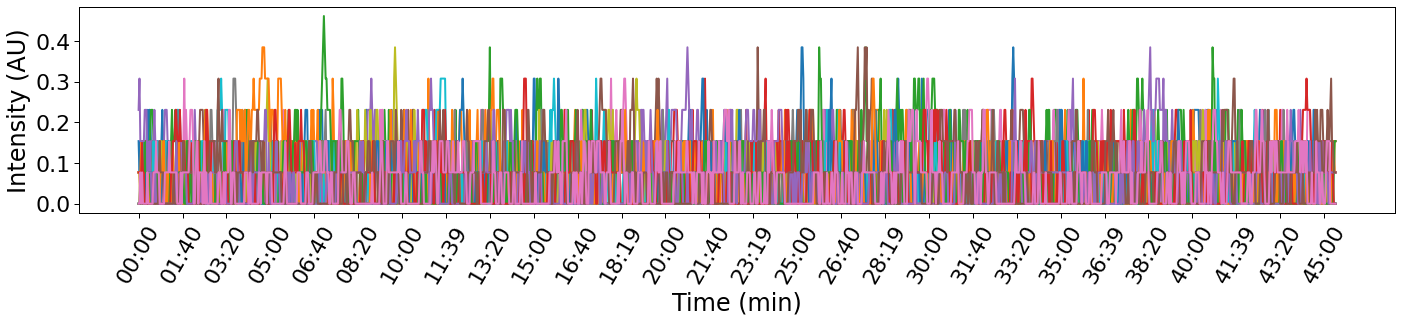

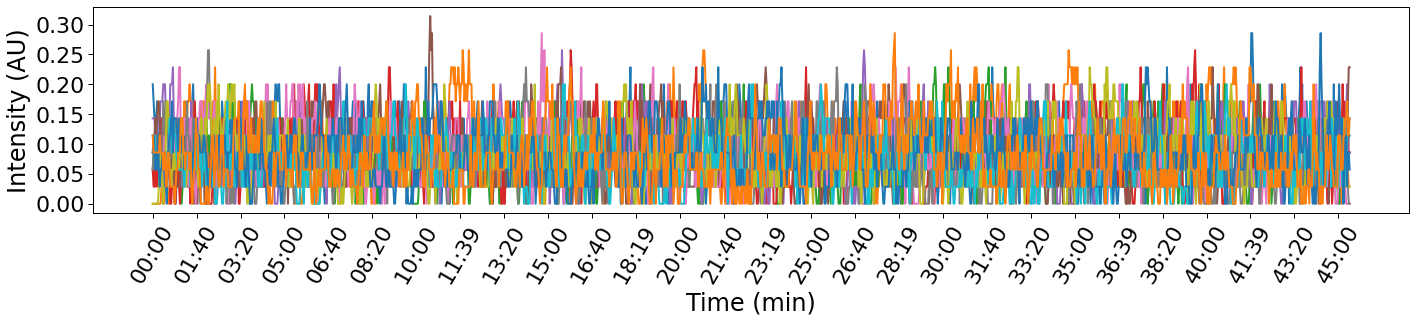

In [134]:
# base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
roi = 19
version='v4'
analysis = f'HMM_Combined_{version}'


for study, k in zip(['Study1', 'Study2'], [17,12]):
    concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0))
    with sns.plotting_context(context='paper', font_scale=2.5):
        f,a = plt.subplots(figsize=(20,5))
        a.plot(concord, linewidth=2)
        a.set_xticks(range(0, concord.shape[0], 50))
        a.set_xticklabels(rec_to_time(range(0, concord.shape[0], 50), TR=2.0), rotation=60)
        a.set_ylabel('Intensity (AU)')
        a.set_xlabel('Time (min)')
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_State_Concordance_k{k}_ROI{roi}_{version}.pdf'))



<AxesSubplot:>

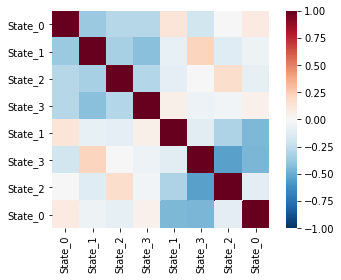

In [476]:
roi = 32
s1_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_k4_ROI{roi}_{version}_aligned.csv'), index_col=0))
s2_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_k4_ROI{roi}_{version}_aligned.csv'), index_col=0))
s2_concord = s2_concord.iloc[:,align_states(s1_concord, s2_concord, return_index=True)]
sns.heatmap(pd.concat([s1_concord, s2_concord], axis=1).corr(), square=True, cmap='RdBu_r', vmin=-1, vmax=1)


In [135]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

s1_32 = calc_max_cluster_consensus_concordance(roi=32, k=4, study='Study1', plot=False)
s2_32 = calc_max_cluster_consensus_concordance(roi=32, k=4, study='Study2', plot=False)
s1_4 = calc_max_cluster_consensus_concordance(roi=4, k=6, study='Study1', plot=False)
s2_4 = calc_max_cluster_consensus_concordance(roi=4, k=7, study='Study2', plot=False)
s1_19 = calc_max_cluster_consensus_concordance(roi=19, k=17, study='Study1', plot=False)
s2_19 = calc_max_cluster_consensus_concordance(roi=19, k=12, study='Study2', plot=False)



Study=Study1: ROI=32
{0: 0.3072721375551462, 1: 0.13329700440038417, 2: 0.1593654205905752, 3: 0.21119471712245177}
Max State=0: Consensus=0.3072721375551462

Study=Study2: ROI=32
{0: 0.0715210386079095, 1: 0.39494129619344426, 2: 0.30406657531768916, 3: 0.08107884894259704}
Max State=1: Consensus=0.39494129619344426

Study=Study1: ROI=4
{0: 0.10963741770898605, 1: 0.11025394643875032, 2: 0.11934059809904013, 3: 0.28031249527070484, 4: 0.2072198724428386, 5: 0.14947895760219052}
Max State=3: Consensus=0.28031249527070484

Study=Study2: ROI=4
{0: 0.12462859960880193, 1: 0.0457586494219691, 2: 0.28248140167052865, 3: 0.15141984551293688, 4: 0.12520909598086505, 5: 0.0757285497786362, 6: 0.1288566326594769}
Max State=2: Consensus=0.28248140167052865

Study=Study1: ROI=19
{0: 0.22244214447299393, 1: 0.24628380767802155, 2: 0.20113547341839202, 3: 0.18052895131312569, 4: 0.17420162151667867, 5: 0.11464046537369378, 6: 0.10953727656680438, 7: 0.23515318308960756, 8: 0.2528763709031919, 9: 0

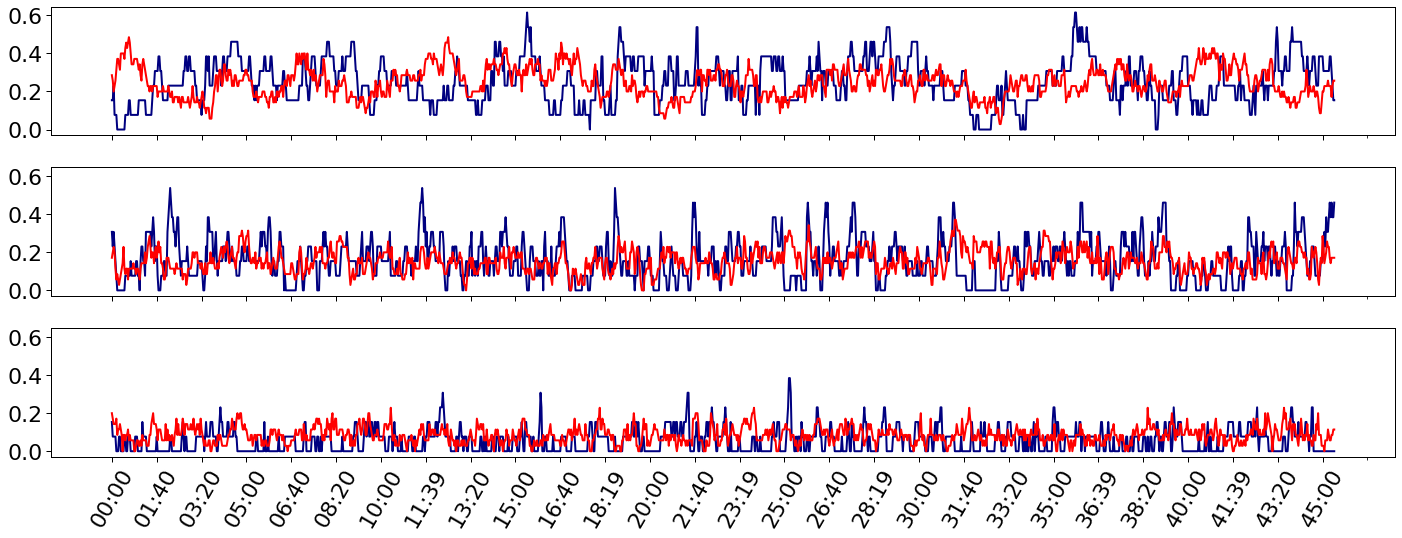

In [166]:
concord_32 = pd.concat([s1_32['Concordance'], s2_32['Concordance']], axis=1)
concord_32.columns = ['Study1', 'Study2']
concord_4 = pd.concat([s1_4['Concordance'], s2_4['Concordance']], axis=1)
concord_4.columns = ['Study1', 'Study2']
concord_19 = pd.concat([s1_19['Concordance'], s2_19['Concordance']], axis=1)
concord_19.columns = ['Study1', 'Study2']
with sns.plotting_context(context='paper', font_scale=2.5):
    f,a = plt.subplots(nrows=3, figsize=(20,8), sharex=True, sharey=True)
    concord_32.plot(linewidth=2, color=['navy','red'], ax=a[0], legend=False)
    concord_4.plot(linewidth=2, color=['navy','red'], ax=a[1], legend=False)
    concord_19.plot(linewidth=2, color=['navy','red'], ax=a[2], legend=False)
    a[2].set_xticks(range(0, concord.shape[0], 50))
    a[2].set_xticklabels(rec_to_time(range(0, concord.shape[0], 50), TR=2.0), rotation=60)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'Max_State_Concordance_{version}.pdf'))



In [162]:
print('vmPFC')
print('\nMean\n', concord_32.mean())
print('\nStd\n', concord_32.std())
print(pearsonr(concord_32['Study1'], concord_32['Study2']))

print('V1')
print('\nMean\n', concord_4.mean())
print('\nStd\n', concord_4.std())
print(pearsonr(concord_4['Study1'], concord_4['Study2']))

print('PCC')
print('\nMean\n', concord_19.mean())
print('\nStd\n', concord_19.std())
print(pearsonr(concord_19['Study1'], concord_19['Study2']))


vmPFC

Mean
 Study1    0.250959
Study2    0.247968
dtype: float64

Std
 Study1    0.116495
Study2    0.077333
dtype: float64
(-0.08592104682547044, 0.001492006642441293)
V1

Mean
 Study1    0.159035
Study2    0.153582
dtype: float64

Std
 Study1    0.110524
Study2    0.060502
dtype: float64
(0.2373939426971794, 6.28830953453298e-19)
PCC

Mean
 Study1    0.054139
Study2    0.084667
dtype: float64

Std
 Study1    0.061610
Study2    0.043642
dtype: float64
(-0.03226954414396579, 0.23365033074581507)


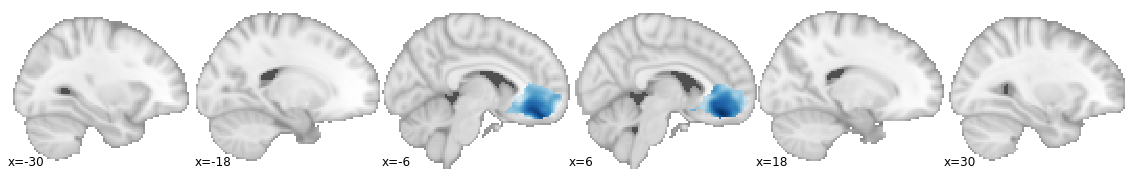

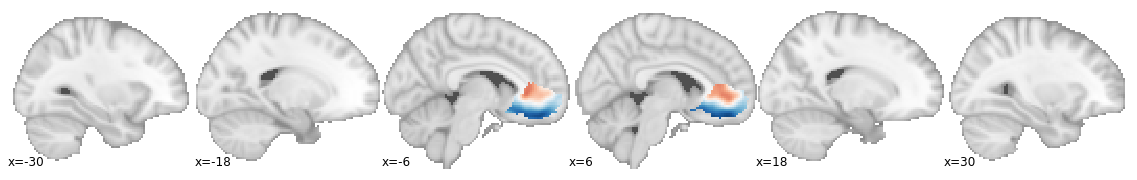

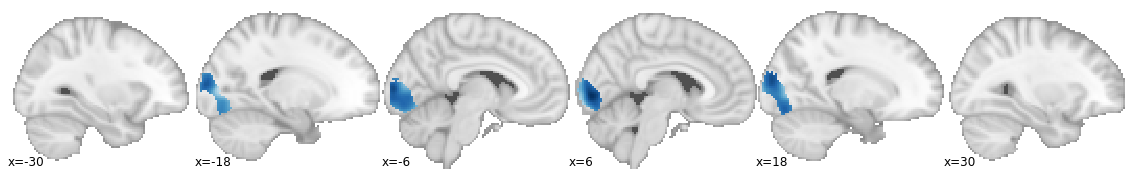

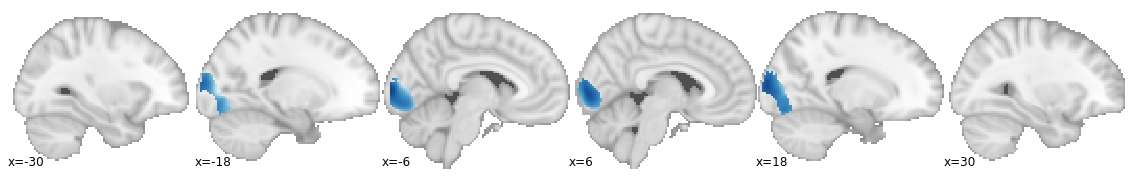

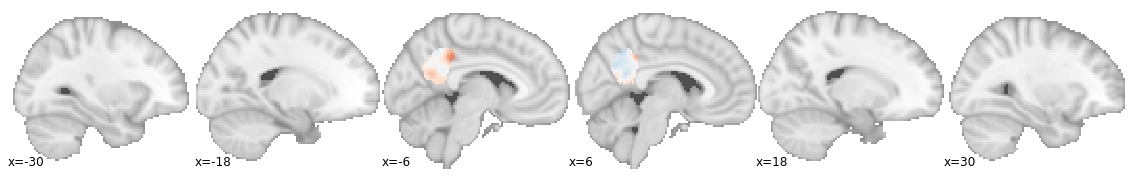

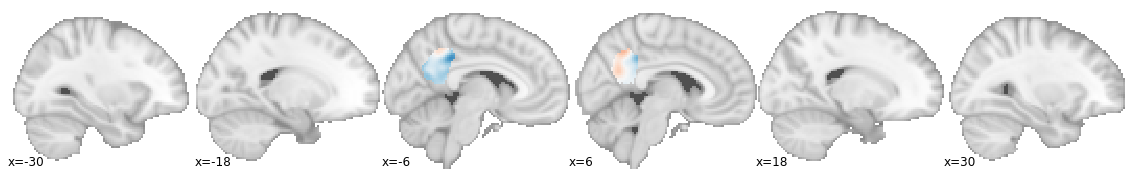

In [138]:
for study, roi, k, output in zip(['Study1', 'Study2', 'Study1', 'Study2', 'Study1', 'Study2'], [32,32,4,4,19,19], [4,4,6,7,17,12], [s1_32, s2_32, s1_4, s2_4, s1_19, s2_19]):
    plot_stat_map(output['Weights'].mean().to_nifti(), display_mode='x', cmap='RdBu_r', cut_coords=range(-30, 31, 12), colorbar=False)
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{study}_Max_State_Concordance_k{k}_ROI{roi}_{version}.png'), dpi=300)


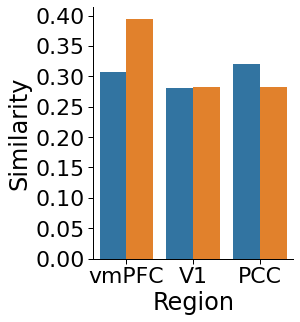

In [160]:
max_consensus = pd.DataFrame({'vmPFC':{'Study1':s1_32['Consensus'][0],'Study2':s2_32['Consensus'][1]},
                              'V1':{'Study1':s1_4['Consensus'][3], 'Study2':s2_4['Consensus'][2]},
                             'PCC':{'Study1':s1_19['Consensus'][10], 'Study2':s2_19['Consensus'][0]}})
max_consensus['Study'] = max_consensus.index
max_consensus = max_consensus.melt(id_vars='Study', value_vars=['vmPFC', 'V1','PCC'], value_name='Similarity', var_name='Region')

with sns.plotting_context(context='paper', font_scale=2.5):
    sns.catplot(data=max_consensus, x='Region', y='Similarity', hue='Study', kind='bar',
                aspect=.9, legend=False)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'Max_Spatial_Similarity.pdf'))


## Plot ROI TimeSeries

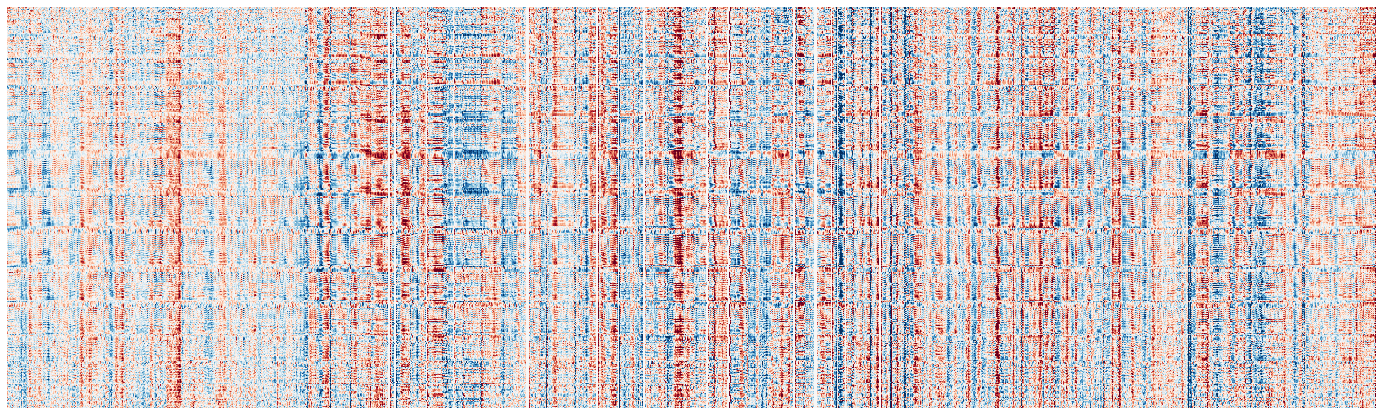

In [177]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'


# subs = 17, 19

roi = 32
episode = 'ep01'
version = 'v4'
var_exp = .9
analysis = f'HMM_Combined_{version}'
study = 'Study2'
k = 4

file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
f = file_list[20]
dat = pd.read_csv(f)
sub = os.path.basename(f).split('_')[0]

with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(nrows=1, figsize=(20,7))
    sns.heatmap(zscore(dat).T, cmap='RdBu_r', ax=a, yticklabels=False, cbar=False, vmin=-2.5, vmax=2.5)
    a.set_xticks(range(0, s1_concord.shape[0], 50))
    a.set_xticklabels(rec_to_time(range(0, s1_concord.shape[0], 50), TR=2.0), rotation=60)
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{sub}_ROI{roi}_voxel_timeseries_heatmap.png'), dpi=300)


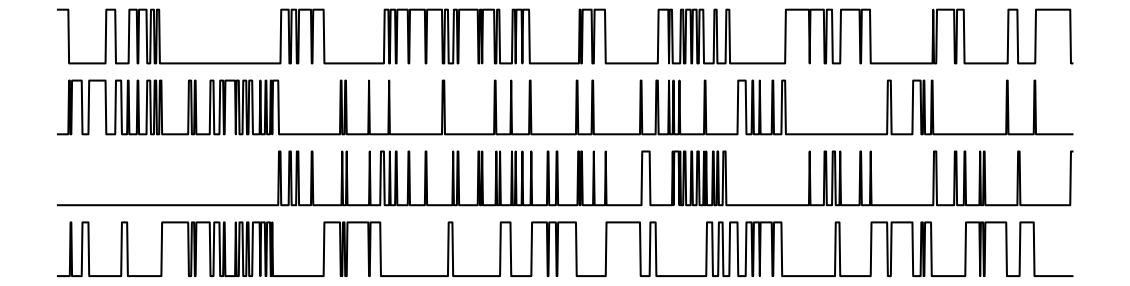

In [172]:
predicted = pd.read_csv(os.path.join(base_dir, 'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0)
predicted = predicted.query('Subject==@sub')

f,a = plt.subplots(nrows=k, figsize=(20,5), sharey=True, sharex=True)
for s in range(k):
    a[s].plot(predicted['Viterbi'] == s, color='k',linewidth=2)
    a[s].axis('off')
plt.savefig(os.path.join(base_dir, 'Figures', analysis, f'{sub}_ROI{roi}_predicted_state.pdf'))


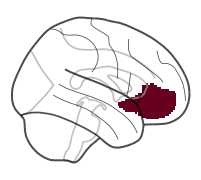

In [181]:
plot_glass_brain(mask_x[roi].to_nifti(), display_mode='x', cmap='RdBu_r', plot_abs=False)
plt.savefig(os.path.join(base_dir,'Figures', analysis, f'vmPFC_Mask.pdf'))
plt.savefig(os.path.join(base_dir,'Figures', analysis, f'vmpFC_Mask.png'), dpi=300)


## Create Average Transition Probability Matrix

In [175]:
roi=32
study = 'Study2'
version = 'v4'
analysis = f'HMM_Combined_{version}'
# base_dir = '/Volumes/Engram/Data/vmpfc/'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

file_list = glob.glob(os.path.join(base_dir, 'Analyses', analysis, 'Aligned_Transition_Probability_Matrix', f'HMM_TransitionMatrix_{study}_*k{k}_ROI{roi}_{version}_aligned.csv'))

f = file_list[0]
all_tm = []
for f in file_list:
    all_tm.append(pd.read_csv(f))
all_tm = np.dstack(all_tm)
transition_prob_mean = np.mean(all_tm, axis=2)
transition_prob_sd = np.std(all_tm, axis=2)
transition_prob_mean

array([[0.82074184, 0.06477839, 0.06217063, 0.05230914],
       [0.04526346, 0.88967269, 0.03920534, 0.02585851],
       [0.04332896, 0.03996077, 0.88976093, 0.02694935],
       [0.06532496, 0.05175935, 0.04514649, 0.83776921]])

In [176]:
transition_prob_sd

array([[0.19406746, 0.0996772 , 0.12146062, 0.09871206],
       [0.09654824, 0.1323068 , 0.07180929, 0.02122961],
       [0.06767292, 0.0428459 , 0.14328698, 0.04245804],
       [0.10217814, 0.07001749, 0.08290619, 0.18556509]])

## Plot Spatial and Temporal Similarity for Supplementary Tables
### Spatial Similarity

In [62]:
version = 'v4'
analysis = f'HMM_Combined_{version}'
roi_states = {'Study1':{4:6, 19:17, 32:4},'Study2':{4:7, 19:12, 32:4}}

summary_mean = []
for study in tqdm(['Study1', 'Study2']):
    for roi in [4, 19, 32]:
        file_list = glob.glob(os.path.join(base_dir, 'Analyses', analysis, f'HMM_Patterns_{study}_*_k{roi_states[study][roi]}_ROI{roi}_{version}_aligned.nii.gz'))
        data = Brain_Data(file_list)
        sim = 1 - data.distance(metric='correlation')
        clusters = np.tile(np.arange(0, roi_states[study][roi]), len(file_list))

        spatial_mean = sim.cluster_summary(clusters=clusters, metric='mean', summary='within')
        spatial_mean['Study'] = study
        spatial_mean['ROI'] = roi
        summary_mean.append(spatial_mean)
summary_mean = pd.DataFrame(summary_mean)
summary_mean.to_csv(os.path.join(base_dir, 'Analyses',analysis,f'HMM_Patterns_Spatial_Similarity_{version}.csv'))



100%|██████████| 2/2 [01:52<00:00, 56.21s/it]


### Temporal Similarity

In [123]:
version = 'v4'
analysis = f'HMM_Combined_{version}'
roi_states = {'Study1':{4:6, 19:17, 32:4},'Study2':{4:7, 19:12, 32:4}}
episode = 'ep01'

all_mean = []; all_std = [];
for study in tqdm(['Study1', 'Study2']):
    for roi in [4, 19, 32]:
        dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{roi_states[study][roi]}_ROI{roi}_{version}_aligned.csv'), index_col=0)
        summary_mean, summary_std = {},{}
        summary_mean = create_average_concordance(dat).mean()
        summary_std = create_average_concordance(dat).std()
        summary_mean['Study'] = study
        summary_mean['ROI'] = roi
        summary_std['Study'] = study
        summary_std['ROI'] = roi
        all_mean.append(summary_mean)
        all_std.append(summary_std)
all_mean = pd.DataFrame(all_mean)
all_std = pd.DataFrame(all_std)
all_mean.to_csv(os.path.join(base_dir, 'Analyses',analysis,f'HMM_Patterns_Temporal_Similarity_Mean_{version}.csv'))
all_std.to_csv(os.path.join(base_dir, 'Analyses',analysis,f'HMM_Patterns_Temporal_Similarity_Std_{version}.csv'))


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


# Plot Pattern Recurrence

In [22]:
base_dir = '/Volumes/Engram/Data/vmpfc'

episode = 'ep01'
version = 'v4'
var_exp = .9
analysis = f'HMM_Combined_{version}'
pca = False

roi_recurr = {}
for roi in [4, 32, 19]:
    study_recurr = {}
    for study in ['Study1', 'Study2']:
        file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
        all_recurr = []
        for f in tqdm(file_list):
            # Load Data
            dat = pd.read_csv(f)
            sub = os.path.basename(f).split('_')[0]
            
            if pca:
                # Perform PCA
                pca = PCA(n_components=var_exp)
                reduced = pca.fit_transform(dat)

                # Plot Pattern Recurrence
                recurr = 1 - pairwise_distances(reduced, metric='correlation')
                with sns.plotting_context(context='paper', font_scale=1.75):
                    plot_recurrence(recurr, cmap='RdBu_r', vmin=-1, vmax=1)
                    plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_{sub}_ROI{roi}_PCA.png'), dpi=300)
            else:
                # Plot Pattern Recurrence
                recurr = 1 - pairwise_distances(dat, metric='correlation')
                with sns.plotting_context(context='paper', font_scale=1.75):
                    plot_recurrence(recurr, cmap='RdBu_r', vmin=-1, vmax=1)
                    plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_{sub}_ROI{roi}.png'), dpi=300)
                
            plt.close()
            all_recurr.append(recurr)
        study_recurr[study] = all_recurr
    roi_recurr[roi] = study_recurr

# Write to File
for roi in [4, 32, 19]:
    for study in ['Study1', 'Study2']:
        out = Adjacency(roi_recurr[roi][study], matrix_type='similarity')
        if pca:
            out.write(os.path.join(base_dir, 'Analyses', 'PatternRecurrence', f'{study}_Subject_Pattern_Similarity_ROI{roi}_PCA.csv'))
        else:
            out.write(os.path.join(base_dir, 'Analyses', 'PatternRecurrence', f'{study}_Subject_Pattern_Similarity_ROI{roi}.csv'))

100%|██████████| 35/35 [05:25<00:00,  9.30s/it]


## Compute T-Test on Pattern Recurrence Matrices

Study1 - ROI19, fdr threshold = 7.410636463379199e-05
Study2 - ROI19, fdr threshold = 0.0028529102939045016


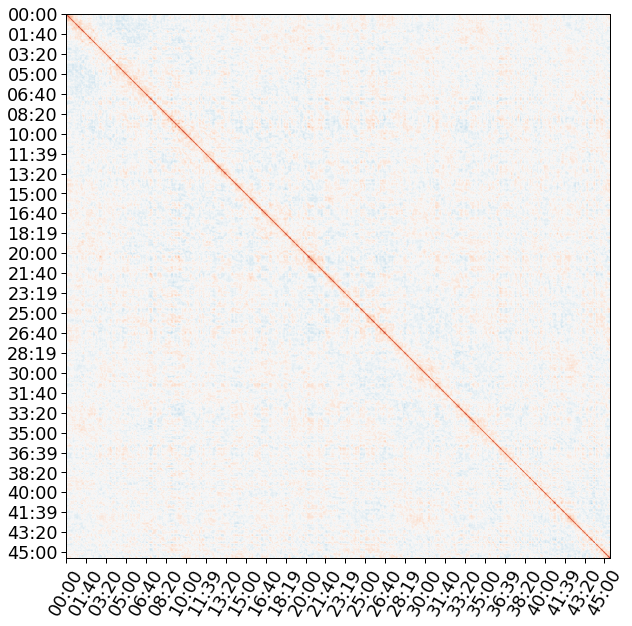

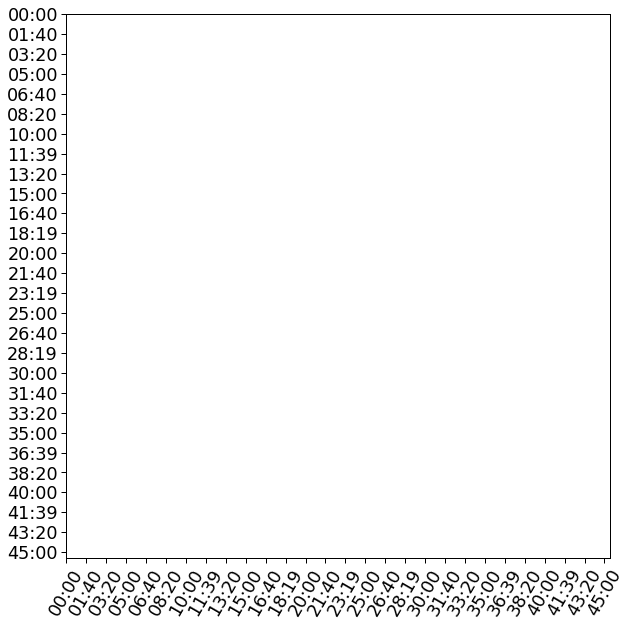

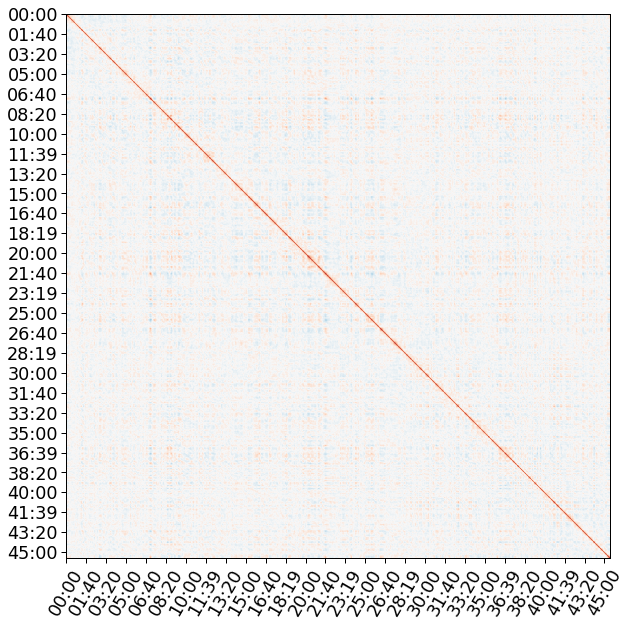

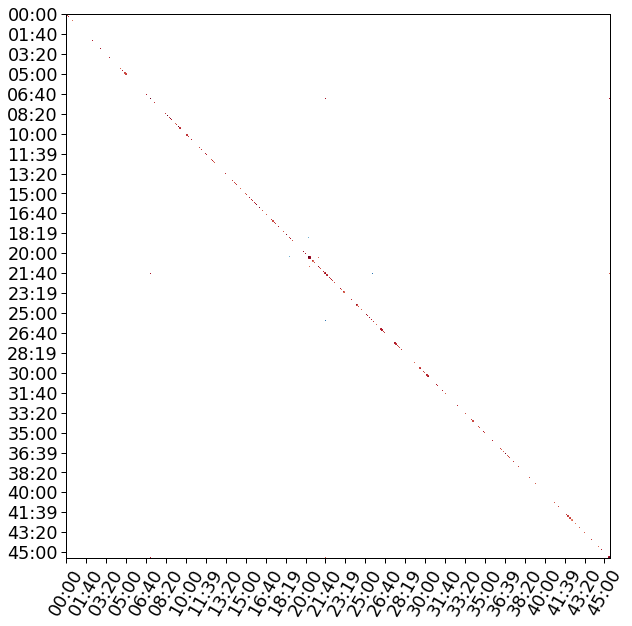

In [23]:
for study in ['Study1', 'Study2']:
    for roi in [4, 32, 19]:
        # Plot Mean
        out = Adjacency(roi_recurr[roi][study], matrix_type='similarity')
        out_mn = np.tanh(out.r_to_z().mean().squareform()) + np.diag(np.ones(out.square_shape()[0]))
        with sns.plotting_context(context='paper', font_scale=2):
            plot_recurrence(out_mn, cmap='RdBu_r', vmin=-1, vmax=1)
            if pca:
                plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_ROI{roi}_Average_PCA.png'), dpi=300)
            else:
                plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_ROI{roi}_Average.png'), dpi=300)
                
        # Plot FDR Thresholded T-Test
        stats = out.r_to_z().ttest()
        fdr_thr = fdr(stats['p'].data)
        print(f"{study} - ROI{roi}, fdr threshold = {fdr_thr}")
        t_thresh = stats['t'].copy()
        t_thresh.data[stats['p'].data > fdr_thr] = np.nan
        t_thresh_np = t_thresh.squareform() + np.diag(np.ones(t_thresh.square_shape()[0]))
        with sns.plotting_context(context='paper', font_scale=2):
            plot_recurrence(t_thresh_np, cmap='RdBu_r', vmin=-10, vmax=10)
            if pca:
                plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_ROI{roi}_T_FDR_PCA.png'), dpi=300)
            else:
                plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_ROI{roi}_T_FDR.png'), dpi=300)


## Plot Recurrence Matrix Spatiotemporal Similarity 

Study1 ROI=19, mean correlation=0.038, std=0.016
Study2 ROI=19, mean correlation=0.052, std=0.028


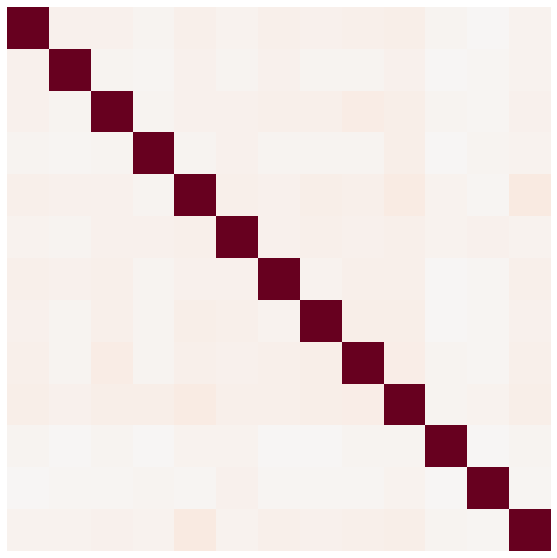

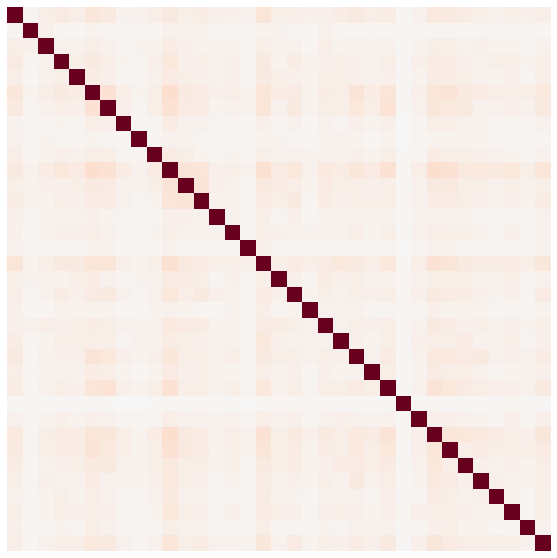

In [25]:
for study in ['Study1', 'Study2']:
    for roi in [4, 32, 19]:
        out = Adjacency(roi_recurr[roi][study], matrix_type='similarity')
        out_dist = out.distance(metric='correlation')
        out_dist.data = 1 - out_dist.data
        out_dist_ = out_dist.squareform() + np.diag(np.ones(out_dist.square_shape()[0]))
        print(f"{study} ROI={roi}, mean correlation={out_dist.mean():.02}, std={out_dist.std():.02}")
        with sns.plotting_context(context='paper', font_scale=2):
            plot_recurrence(out_dist_, cmap='RdBu_r', vmin=-1, vmax=1)
            plt.axis('off')
            if pca:
                plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_ROI{roi}_SpatioTemporal_PCA.png'), dpi=300)
            else:
                plt.savefig(os.path.join(base_dir, 'Figures', 'PatternRecurrence', f'{study}_ROI{roi}_SpatioTemporal.png'), dpi=300)


## Plot All subjects Recurrence for Supplemental

In [34]:
episode = 'ep01'
var_exp = 0.9
grid_size = {'Study1':{'cols':5, 'rows':3}, 'Study2':{'cols':5, 'rows':7}}
study = 'Study1'

for study in ['Study1', 'Study2']:
    for roi in [19]:
#     for roi in [4,32,19]:
        file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
        f,a = plt.subplots(nrows=grid_size[study]['rows'], ncols=grid_size[study]['cols'], figsize=(grid_size[study]['cols']*5,grid_size[study]['rows']*5), sharey=True, sharex=True)
        all_out = {}
        counter = 0
        for i,f in enumerate(file_list):
            sub = os.path.basename(f).split('_')[0]
            dat = pd.read_csv(f, index_col=0)
            pca = PCA(n_components=var_exp)
            reduced = pca.fit_transform(dat)
            all_out[sub] = 1 - pairwise_distances(reduced, metric='correlation')
            sns.heatmap(all_out[sub], square=True, yticklabels=False, xticklabels=False,
                        vmin=-1, vmax=1, cmap='RdBu_r', ax=a[int(np.floor(i/grid_size[study]['cols'])), counter], cbar=False)
            a[int(np.floor(i/grid_size[study]['cols'])), counter].set_title(sub, fontsize=18)
            if counter >= (grid_size[study]['cols']-1):
                counter = 0
            else:
                counter+=1
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir,'Figures','PatternRecurrence', f'{study}_All_Subjects_Recurrence_ROI{roi}.png'), dpi=150)
        plt.close()

# Duration of Group-HMM States
- Need to do remapping of vmPFC states

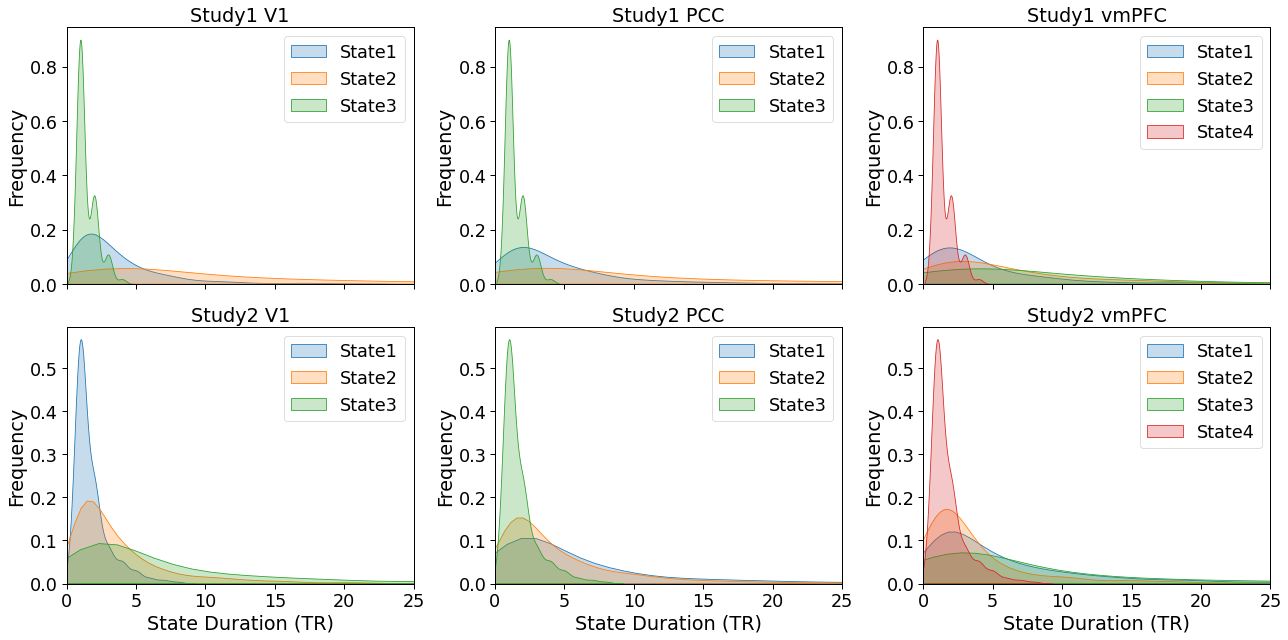

In [268]:
def count_sequence_runs(sequence):
    '''Count the number of consecutive times a sequence is repeated if greater than 1'''
    sequence = np.array(sequence)
    state_count = {x:0 for x in np.unique(sequence)}
    sequence_count = []
    prev_state = np.nan
    for i in sequence:
        if i == prev_state:
            state_count[i] += 1
        else:
            if np.sum(list(state_count.values())) > 0:
                state = [x for x in state_count if state_count[x] > 0][0]
                sequence_count.append({'State':state, 'Count':state_count[state]}                )
            state_count = {x:0 for x in np.unique(sequence)}
        prev_state = deepcopy(i)
    return pd.DataFrame(sequence_count)

study = 'Study1'
roi = 4
episode = 'ep01'
roi_states = {4:3, 19:3, 32:4}
roi_name = {4:'V1', 19:'PCC', 32:'vmPFC'}
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
max_length = 25

all_sequence_counts = []
for study in ['Study1', 'Study2']:
    for roi in [4,19,32]:
        data = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_{episode}_k{roi_states[roi]}_ROI{roi}_{version}.csv'), index_col=0)
        sub_list = data['Subject'].unique()
        for sub in sub_list:
            sequence = data.query('Subject==@sub')['Viterbi'].values
            sequence_count = count_sequence_runs(sequence)
            sequence_count['Study'] = study
            sequence_count['Subject'] = sub
            sequence_count['ROI'] = roi
            all_sequence_counts.append(sequence_count)
all_sequence_counts = pd.concat(all_sequence_counts, axis=0)

with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(nrows=2, ncols=3, figsize=(18,9), sharex=True, sharey=False)
    for i,study in enumerate(['Study1','Study2']):
        for j,roi in enumerate([4,19, 32]):
            tmp_data = all_sequence_counts.query('ROI==@roi&Study==@study')
            for state in tmp_data['State'].unique():
                sns.distplot(tmp_data.query('State==@state')['Count'], hist=False, kde_kws={"shade": True}, ax=a[i,j])
            a[i,j].set_xlim(0, max_length)
            a[i,j].legend(['State1','State2','State3','State4'])
            a[i,j].set_xlabel('State Duration (TR)')
            a[i,j].set_ylabel('Frequency')
            a[i,j].set_title(f'{study} {roi_name[roi]}')
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'Figures', 'Spatiotemporal_Autocorrelation', 'GroupHMM_State_Duration.pdf'))
plt.savefig(os.path.join(base_dir, 'Figures', 'Spatiotemporal_Autocorrelation', 'GroupHMM_State_Duration.png'), dpi=300)

# HMM State Univariate Contrast
## Group HMM 
Run first level GLM comparing activity in each vmPFC HMM state compared to the rest of the states.


In [156]:
roi=32
k = 4
study = 'Study1'
version = 'v3'
analysis = f'HMM_Combined_{version}'
data_dir = '/Volumes/Engram/Data/vmpfc/'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'


for study in ['Study1','Study2']:
    predicted_states = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_k{k}_ROI{roi}_{version}.csv'), index_col=0)
    if study == 'Study1':
        state_remapping_dict = {0:1,1:3,2:2,3:0}
    else:
        state_remapping_dict = {0:3,1:1,2:2,3:0}

    predicted_states['Viterbi'] = predicted_states['Viterbi'].map(state_remapping_dict)
    sub_list = predicted_states['Subject'].unique()
    for sub in tqdm(sub_list):
        sdat = Brain_Data(os.path.join(data_dir, 'Data', study, 'Denoised', f'{sub}_{episode}_smooth6_denoised.hdf5'))

        sub_connectivity = []
        for state in range(k):
            sdat.X = Design_Matrix({'Intercept': np.ones(len(sdat)), 'HMM':(predicted_states.query('Subject==@sub')['Viterbi'] == state).astype(int)}, sampling_freq=1/2)
            stats = sdat.regress()
            sub_connectivity.append(stats['beta'][1])
        sub_connectivity = Brain_Data(sub_connectivity)
        sub_connectivity.write(os.path.join(base_dir,'Analyses', 'HMM_Connectivity', f'{study}_{sub}_{episode}_State_Connectivity_k{k}_roi{roi}_{version}.nii.gz'))


100%|██████████| 35/35 [36:47<00:00, 63.08s/it]


### Run Group One Sample T-Test

In [170]:
roi=32
k = 4
study = 'Study1'
version = 'v3'
analysis = f'HMM_Combined_{version}'
data_dir = '/Volumes/Engram/Data/vmpfc/'
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'


c1 = [1, 0, 0, 0]
c2 = [0, 1, 0, 0]
c3 = [0, 0, 1, 0]
c4 = [0, 0, 0, 1]

file_list = glob.glob(os.path.join(base_dir,'Analyses', 'HMM_Connectivity', f'{study}_*_{episode}_State_Connectivity_k{k}_roi{roi}_{version}.nii.gz'))

state1, state2, state3, state4 = [], [], [], []
for f in file_list:
    sdat = Brain_Data(f)
    state1.append(sdat*c1)
    state2.append(sdat*c2)
    state3.append(sdat*c3)
    state4.append(sdat*c4)

thresh = 0.05
# for thresh in [.05, .01, .005, .001]:
views = ["x", "y", "z"]
coords = [range(-50, 50, 9), range(-60, 50, 9), range(-30, 51,7)]
for i,state in enumerate([state1, state2, state3, state4]):
    stats = Brain_Data(state).ttest(threshold_dict={'fdr':thresh})
    stats['t'].write(os.path.join(base_dir,'Analyses', 'HMM_Connectivity', f'{study}_{episode}_State_Contrast_State{i+1}_unthresholded_k{k}_roi{roi}_{version}.nii.gz'))
    stats['thr_t'].write(os.path.join(base_dir,'Analyses', 'HMM_Connectivity', f'{study}_{episode}_State_Contrast_State{i+1}_fdr{thresh}_k{k}_roi{roi}_{version}.nii.gz'))
#     stats['thr_t'].plot()
    for view,coord in zip(views, coords):
        plot_stat_map(stats['thr_t'].to_nifti(), display_mode=view, cut_coords=coord, draw_cross=False)
        plt.savefig(os.path.join(base_dir,'Figures', 'HMM_Connectivity', f'{study}_{episode}_State{i+1}_Contrast_fdr{thresh}_k{k}_roi{roi}_{version}_{view}.png'), dpi=300)
        plt.close()


## Decode State Contrasts with Neurosynth

In [137]:
def plot_polar(data, n_top=3, overplot=False, palette='husl', 
               reorder=False, method='weighted', metric='correlation', labels=None,
               label_size=26, threshold=None, max_val=None,
               alpha_level=.8, legend=False, error_bars=None, line_width=4, line_alpha=.8):
    """ Make a polar plot
    data - Tabular data of shape features x classes with labels as index
    n_top - Number of features to select
    selection - Selection method to use `
                (top = M strongest for each class; std = N with greatest std across all)
    overplot - Overlap plots for each class?
    labels - Subset of features to use (overrides auto selection by n_top)
    palette - Color palette to use (can be label or list of colors from seaborn)
    reorder - If True, uses hierarchical clustering to reorder axis
    method - Method to use for clustering
    metric - Metric to use for clustering
    label_size - X axis label size
    threshold - Value to draw an optional line that denotes significance threshold
    max_val - Maximum value of y axis
    alpha_level - transparency value for lines
    legend - Show legend?
    error_bars - Option bootstrapped data to draw error bars
    line_width - width of lines
    line_alpha - alpha of lines
    """

    data = data.iloc[:n_top,:]
    n_panels = data.shape[1]
    
    if labels is not None:
        data = data.loc[labels,:]
    else:
        labels=data.index

    if error_bars is not None:
        error_bars = error_bars.loc[labels,:]

    if reorder is True:
        # Use hierarchical clustering to order
        from scipy.spatial.distance import pdist
        from scipy.cluster.hierarchy import linkage, leaves_list
        dists = pdist(data, metric=metric)
        pairs = linkage(dists, method=method)
        pairs[pairs < 0] = 0
        order = leaves_list(pairs)
        data = data.iloc[order,:]

        if error_bars is not None:
            error_bars = error_bars.iloc[order,:]

        labels = [labels[i] for i in order]


    theta = np.linspace(0.0, 2 * np.pi, len(labels), endpoint=False)
    
    ## Add first
    theta = np.concatenate([theta, [theta[0]]])
    if overplot:
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(polar=True))
        fig.set_size_inches(10, 10)
    else:
        fig, axes = plt.subplots(n_panels, 1, sharex=False, sharey=False,
                             subplot_kw=dict(polar=True))
        fig.set_size_inches((6, 6 * n_panels))
        
    if isinstance(palette, str):
        from seaborn import color_palette
        colors = color_palette(palette, n_panels)
    else:
        colors = palette

    for i in range(n_panels):
        if overplot:
            alpha = alpha_level
        else:
            ax = axes[i]
            alpha = alpha_level

        if max_val is None:
            if error_bars is not None:
                max_val = data.values.max() + error_bars.values.max() + data.values.max() * .02
            else:
                max_val = data.values.max()
        
        ax.set_ylim(data.values.min(), max_val)
        
        d = data.iloc[:,i].values
        d = np.concatenate([d, [d[0]]])
        name = data.columns[i]

        if error_bars is not None:
            e = error_bars.iloc[:,i].values
            e = np.concatenate([e, [e[0]]])
        else:
            e = None

        if error_bars is not None:
            ax.errorbar(theta, d, yerr=e, capsize=0, color=colors[i], elinewidth = 3, linewidth=0)
        else:
            ax.plot(theta, d, alpha=line_alpha - 0.1, color=colors[i], linewidth=line_width, label=name)
            ax.fill(theta, d, ec='k', alpha=alpha, color=colors[i], linewidth=line_width)

        ax.set_xticks(theta)
        ax.set_rlabel_position(11.12)
        ax.set_xticklabels(np.concatenate([labels,[labels[0]]]), fontsize=label_size)
        [lab.set_fontsize(12) for lab in ax.get_yticklabels()]

    
    if threshold is not None:
        theta = np.linspace(0.0, 2 * np.pi, 999, endpoint=False)
        theta = np.concatenate([theta, [theta[0]]])
        d = np.array([threshold] * 1000)
        ax.plot(theta, d, alpha=1, color='black', linewidth=2, linestyle='--')

    if legend is True:
        ax.legend(bbox_to_anchor=(1.15, 1.1))

    plt.tight_layout()

    return labels, data

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

In [11]:
topic_labels = pd.read_excel(os.path.join('/Users/lukechang/Dropbox/NeurosynthTopicMaps_N80/','Table_S1.xlsx'))

file_list = glob.glob(os.path.join('/Users/lukechang/Dropbox/NeurosynthTopicMaps_N80/','topic*pFgA_z.nii.gz'))
sort_nicely(file_list)
ns_topics = Brain_Data(file_list)

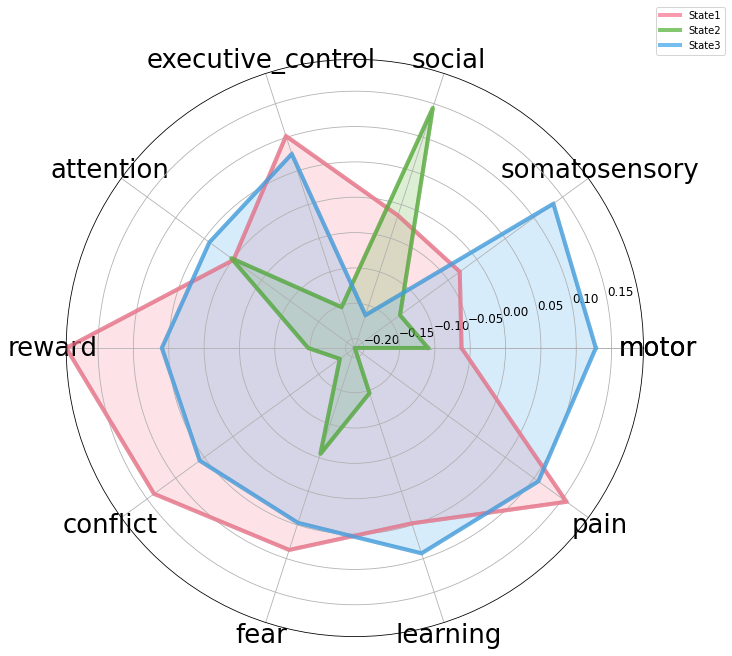

In [139]:
study = 'Study2'
episode = 'ep01'
thresh = 0.05
k=4
roi = 32
version = 'v3'

topic_labels = pd.read_excel(os.path.join('/Users/lukechang/Dropbox/NeurosynthTopicMaps_N80/','Table_S1.xlsx'))
state_files = glob.glob(os.path.join(base_dir,'Analyses', 'HMM_Connectivity', f'{study}_*State_Contrast_State*_fdr{thresh}_k{k}_roi{roi}_{version}.nii.gz'))
sort_nicely(state_files)
hmm_states = Brain_Data(state_files)

r = hmm_states.similarity(ns_topics)
topic_labels = pd.concat([topic_labels,pd.DataFrame(r, columns=[f'State{x+1}' for x in range(k)])],axis=1)
topic_labels.index = topic_labels['Topic Label']

_ = plot_polar(topic_labels.query('Classification=="Include"')[['State1','State2','State3']], n_top=10, overplot=True, legend=True, alpha_level=.2)
plt.savefig(os.path.join(base_dir,'Figures', 'HMM_Connectivity', f'Neurosynth_Decoding_Contrast_FDR.pdf'))


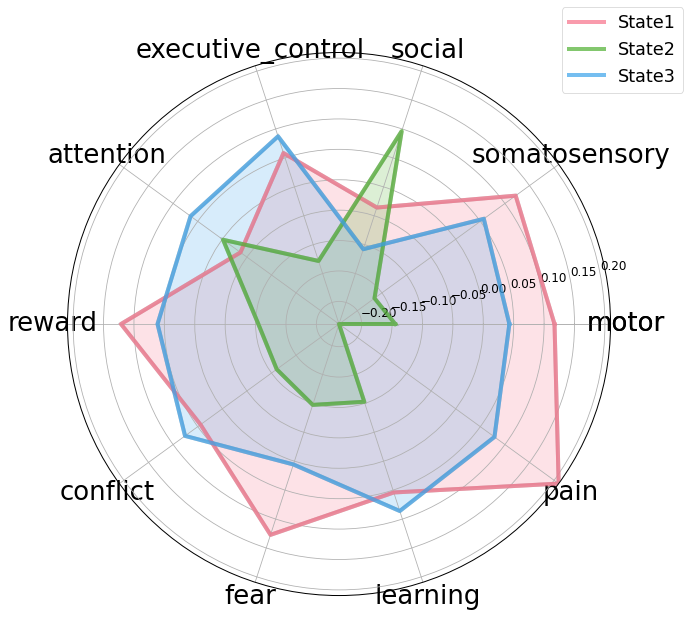

In [138]:
study = 'Study2'
episode = 'ep01'
thresh = 0.05
k=4
roi = 32
version = 'v3'

topic_labels = pd.read_excel(os.path.join('/Users/lukechang/Dropbox/NeurosynthTopicMaps_N80/','Table_S1.xlsx'))
state_files = glob.glob(os.path.join(base_dir,'Analyses', 'HMM_Connectivity', f'*_State_Contrast_State*_unthresholded_k{k}_roi{roi}_{version}.nii.gz'))
sort_nicely(state_files)
hmm_states = Brain_Data(state_files)

r = hmm_states.similarity(ns_topics)
topic_labels = pd.concat([topic_labels,pd.DataFrame(r, columns=[f'State{x+1}' for x in range(k)])],axis=1)
topic_labels.index = topic_labels['Topic Label']

with sns.plotting_context(context='paper', font_scale=2):
    _ = plot_polar(topic_labels.query('Classification=="Include"')[['State1','State2','State3']], n_top=10, overplot=True, legend=True, alpha_level=.2)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures', 'HMM_Connectivity', f'Neurosynth_Decoding_Contrast_unthresholded.pdf'))
